# **Модель машинного обучения, предсказывающая отключения электроэнергии на ЛЭП 110 кВ**


Обеспечение надежного электроснабжения потребителей при условии поставки им качественной электрической энергии является необходимым условием эффективного развития народного хозяйства. Завышенная протяжённость, совместно с износом сетей приводит к тому, что поток отказов в них доходит до 37 год-1 на 100 км, а время восстановления – до 8 ч. Ущербы от недоотпуска электроэнергии составляют от 30 до 300 руб./кВт·ч и более. Влияет протяжённость и состояние сети и на безопасность эксплуатации. С учётом указанных выше и других проблем в электроснабжении сельских потребителей актуальными являются вопросы поиска способов прогнозирования мест, наиболее подверженных к перерывам в электроснабжении.  

**Данные** В наличии имеются данные по отключениям электроэнергии в региональных электрических сетях Орловской области за 2018 по 2023 гг. Также имееются данные по характеристикам линий электропередачи (ЛЭП).

**Цель** - Проанализировать и подготовить данные к обучению модели машинного обучения для прогнозирования возможных отключений электроэнергии на линиях электропередачи на основе  характеристик самих ЛЭП.

**Задачи:**

- Подготовка данных к обработке
- Исследование и обработка данных
- Удаление и создание признаков
- Корреляционный анализ
- Выводы

In [1]:
%%capture

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns

!pip install phik
import phik
from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix

import warnings
warnings.filterwarnings("ignore")

# Подготовка данных

## Загрузка данных

### Данные по отключениям электроэнергии

У нас в наличии четыре датасета:

1. События отключения электроэнергии с 1 января 2018 по 14 октября 2021. Вид технологического отключения: Аварийное, Неотложное, Плановое, Неплановое, Потребительское, Ограничения

2. События отключения электроэнергии с 1 января 2021 г. по 31 декабря 2022 г. Вид технологического отключения: Аварийное.

3. События отключения электроэнергии с 1 января 2022 по 31 декабря 2022. Вид технологического отключения: Аварийное, Неотложное, Плановое, Неплановое, Потребительское, Ограничения

4. События отключения электроэнергии с 1 января 2023 по 31 декабря 2023. Вид технологического отключения: Аварийное, Неотложное, Плановое, Неплановое, Потребительское, Ограничения

Загрузим все датасеты, изучим и конкатенируем их.

In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [9]:
# Загружаем датасет с событиями отключения электроэнергии 2018 - 2021
df = pd.read_excel(open("/content/gdrive/MyDrive/data_outages_2018_21.xlsx", 'rb'), sheet_name='ЖурналОтключений', usecols="B:AF")

# Удаляем ненужные столбцы и строки
df = df.iloc[5:].drop([7,24666], axis=0)

# Переименовываем ячейки
df.iloc[0,19:24] = 'Количество обесточенных ' + df.iloc[1,19:24]
df.iloc[0,1:5] = df.iloc[1,1:5]

# Устанавливаем новые названия столбцов
df.columns = list(df.loc[5])
df = df.drop([5,6], axis=0)
df.head()

,№ п.п.,ДЗО,Филиал(ПО) ДЗО,ПО филиала ДЗО,РЭС,"Электросетевой объект: ЛЭП, ПС",Диспетчерское наименование,Диспетчерское наименование оборудования ПС,Напряжение сети,Дата и время возникновения события,...,"Количество обесточенных населённых пунктов (НП), шт.","Количество обесточенных населения, чел.",Количество обесточенных социально-значимых объектов,"Суммарная отключённая мощность, МВт","Длительность события, ч","Длительность перерывов электроснабжения, ч","Суммарная длительность отключений потребителей, ч (17х24)",Причина отключения,Описание работы РЗА,Причина отключения упрощ
8,1,ПАО «Россети Центр»,Орелэнерго,NaN,Орловский РЭС,ВЛ,ВЛ-10кВ №16 ПС Приборная,NaN,10 (10.5),2018-01-06 03:03:00,...,10,779,10,0.55,0.1167,0.1167,86.2413,06.01.2018 03:03 Отлючился В-10 кВ от Т.О. АПВ...,Оценка не требуется,Токовая отсечка
9,2,ПАО «Россети Центр»,Орелэнерго,NaN,Орловский РЭС,ВЛ,ВЛ 10кВ №37 ПС Володарская,NaN,10 (10.5),2018-01-06 09:48:00,...,29,1574,4,0.2,7.7833,0.8,1156,"9-48 Произведен осмотр КРУН-10кВ,обнаружено, ч...",Правильно,Повреждение КЛ 10 кВ
10,3,ПАО «Россети Центр»,Орелэнерго,NaN,Орловский РЭС,ВЛ,ВЛ-10кВ №28 ПС Володарская,NaN,10 (10.5),2018-01-06 16:17:00,...,NaN,NaN,NaN,NaN,0,NaN,NaN,"16-17 Произвден осмотр КРУН-10кВ,от МТЗ отключ...",Правильно,МТЗ
11,4,ПАО «Россети Центр»,Орелэнерго,NaN,Ливенский РЭС,ВЛ,"ВЛ-0,4кВ ф-1 КТП-10/В.Д-4-160",NaN,0.38,2018-01-09 14:16:00,...,1,48,0,0.021,0.6,0.6,31.2,"Включен АВ-0,4кВ.",Оценка не требуется,Включение АВ
12,5,ПАО «Россети Центр»,Орелэнерго,NaN,Новодеревеньковский РЭС Архив,ВЛ,"ВЛ-0,4кВ КТП 1/С-1-100 Ф-1 н.п.Залесное",NaN,0.38,2018-01-10 10:03:00,...,0,0,0,0.003,3.45,3.45,193.2,Отключение по заявке,NaN,Отключение по заявке


In [10]:
# Загружаем датасет с событиями отключения электроэнергии 2021 - 2022
df2 = pd.read_excel(open("/content/gdrive/MyDrive/data_outages_2021_22.xlsx", 'rb'), sheet_name='ЖурналОтключений', usecols="B:AB")

# Удаляем ненужные столбцы и строки
df2 = df2.iloc[6:].drop([8,5683], axis=0)

# Переименовываем ячейки
df2.iloc[0,16:21] = 'Количество обесточенных ' + df2.iloc[1,16:21]
df2.iloc[0,1:5] = df2.iloc[1,1:5]

# Устанавливаем новые названия столбцов
df2.columns = list(df2.loc[6])
df2 = df2.drop([6,7], axis=0)

df2.head()

,№ п.п.,ДЗО,Филиал(ПО) ДЗО,ПО филиала ДЗО,РЭС,"Электросетевой объект: ЛЭП, ПС",Диспетчерское наименование,Диспетчерское наименование оборудования ПС,Напряжение сети,Дата и время возникновения события,...,"Количество обесточенных трансформаторных подстанций (ТП), шт.","Количество обесточенных населённых пунктов (НП), шт.","Количество обесточенных населения, чел.",Количество обесточенных социально-значимых объектов,"Суммарная отключённая мощность, МВт","Длительность события, ч","Длительность перерывов электроснабжения, ч","Суммарная длительность отключений потребителей, ч (17х24)",Причина отключения,Описание работы РЗА
9,1,ПАО «Россети Центр»,Орелэнерго,NaN,Верховский РЭС,ВЛ,ВЛ-10кВ ф-18 ПС Р.Брод,NaN,10 (10.5),2021-01-01 09:04:00,...,8,5,211,1,0.237,0.2333,0.2333,30.0957,"09ч.04мин. Действием МТЗ отключен В-10кВ №18,А...",Неоценено
10,2,ПАО «Россети Центр»,Орелэнерго,NaN,Верховский РЭС,ВЛ,ВЛ-10кВ Ф-2 ПС Паньково,NaN,10 (10.5),2021-01-01 11:54:00,...,8,3,154,2,0.116,0.05,0.05,3.65,"11ч.54мин. действием МТЗ отключен В-10кВ №2, А...",Неоценено
11,3,ПАО «Россети Центр»,Орелэнерго,NaN,Новосильский РЭС,ВЛ,ВЛ 10кВ №07 ПС Новосиль,NaN,10 (10.5),2021-01-01 18:58:00,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,"18:58 отключился В 10 кВ №7яч.№201 от МТЗ, АПВ...",Неоценено
12,4,ПАО «Россети Центр»,Орелэнерго,NaN,Новосильский РЭС,ВЛ,ВЛ 10кВ №05 ПС Новосиль,NaN,10 (10.5),2021-01-01 18:58:00,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,"18:58 отключился В 10 кВ №5 яч.№102 от МТЗ, АП...",Неоценено
13,5,ПАО «Россети Центр»,Орелэнерго,NaN,Новосильский РЭС,ВЛ,"ВЛ 0,4кВ КТП 037 Ф2 д. Задушное",NaN,0.38,2021-01-01 19:02:00,...,0,1,25,0,0.021,2.3,2.3,43.7,"19:02 поступила заявка,20:59 обнаружили сгорев...",Оценка не требуется


In [11]:
# Загружаем датасет с событиями отключения электроэнергии за 2022
df3 = pd.read_excel(open("/content/gdrive/MyDrive/Журнал отключений 2022.xlsx", 'rb'), sheet_name='ЖурналОтключений', usecols="B:AA")

# Удаляем ненужные столбцы и строки
df3 = df3.iloc[5:].drop([7,8712])

# Переименовываем ячейки
df3.iloc[0,16:21] = 'Количество обесточенных ' + df3.iloc[1,16:21]
df3.iloc[0,1:5] = df3.iloc[1,1:5]

# Устанавливаем новые названия столбцов
df3.columns = list(df3.loc[5])
df3 = df3.drop([5,6], axis=0)

df3.head()

,№ п.п.,ДЗО,Филиал(ПО) ДЗО,ПО филиала ДЗО,РЭС,"Электросетевой объект: ЛЭП, ПС",Диспетчерское наименование,Диспетчерское наименование оборудования ПС,Напряжение сети,Дата и время возникновения события,...,"Количество обесточенных потребителей (точек поставки), ед.","Количество обесточенных трансформаторных подстанций (ТП), шт.","Количество обесточенных населённых пунктов (НП), шт.","Количество обесточенных населения, чел.",Количество обесточенных социально-значимых объектов,"Суммарная отключённая мощность, МВт","Длительность события, ч","Длительность перерывов электроснабжения, ч","Суммарная длительность отключений потребителей, ч (17х24)",Причина отключения
8,1,ПАО «Россети Центр»,Орелэнерго,NaN,NaN,ВЛ,ВЛ 110 кВ Узловая - Орл. Районная с отп.,NaN,110,2022-01-01 08:58:00,...,40,24,1,9619,NaN,3.9,9.35,0.75,30,Осмотром обнаружено: разрушена гирлянда изолят...
9,2,ПАО «Россети Центр»,Орелэнерго,NaN,Ливенский РЭС,ВЛ,ВЛ-10кВ №10 ПС 35/10кВ Вышне-Ольшаное,NaN,10 (10.5),2022-01-01 14:40:00,...,190,13,7,0,0,0.021,7.45,7.45,1415.5,РАБОТЫ НА ЛЭП \ ДЛЯ БЕЗОПАСНОГО ПРОИЗВОДСТВА Р...
10,3,ПАО «Россети Центр»,Орелэнерго,NaN,Ливенский РЭС,ТП,КТП-14/ВО-10-63кВА д. Баранчик,КТП-14/ВО-10-63кВА д. Баранчик,10 (10.5),2022-01-01 14:40:00,...,43,0,1,0,0,0.007,7.45,7.45,320.35,РАБОТЫ НА ПС/ТП \ ЗАМЕНА ОБОРУДОВАНИЯ\n01.01.2...
11,4,ПАО «Россети Центр»,Орелэнерго,NaN,Кромской РЭС,ВЛ,ВЛ-10кВ №5 Дмитровская,NaN,10 (10.5),2022-01-01 15:19:00,...,713,39,23,9,2,0.082,2.1833,2.1833,1556.6929,РАБОТЫ НА ЛЭП \ СРЕДНИЙ РЕМОНТ\n01.01.2022 14:...
12,5,ПАО «Россети Центр»,Орелэнерго,NaN,Орловский РЭС,ВЛ,"ВЛ 0,4 кВ Л-2 ТП Южн-2-10",NaN,0.38,2022-01-01 17:38:00,...,129,0,2,0,0,0.1419,0.7333,0.7333,94.5957,РАБОТЫ НА ЛЭП \ РЕМОНТ ПРОВОДА\n01.01.2022 17:...


In [12]:
# Загружаем датасет с событиями отключения электроэнергии за 2023
df4 = pd.read_excel(open("/content/gdrive/MyDrive/Журнал отключений 2023.xlsx", 'rb'), sheet_name='ЖурналОтключений', usecols="B:AA")

# Удаляем ненужные столбцы и строки
df4 = df4.iloc[5:].drop([7,20518])

# Переименовываем ячейки
df4.iloc[0,16:21] = 'Количество обесточенных ' + df4.iloc[1,16:21]
df4.iloc[0,1:5] = df4.iloc[1,1:5]

# Устанавливаем новые названия столбцов
df4.columns = list(df4.loc[5])
df4 = df4.drop([5,6], axis=0)

df4.head()

,№ п.п.,ДЗО,Филиал(ПО) ДЗО,ПО филиала ДЗО,РЭС,"Электросетевой объект: ЛЭП, ПС",Диспетчерское наименование,Диспетчерское наименование оборудования ПС,Напряжение сети,Дата и время возникновения события,...,"Количество обесточенных потребителей (точек поставки), ед.","Количество обесточенных трансформаторных подстанций (ТП), шт.","Количество обесточенных населённых пунктов (НП), шт.","Количество обесточенных населения, чел.",Количество обесточенных социально-значимых объектов,"Суммарная отключённая мощность, МВт","Длительность события, ч","Длительность перерывов электроснабжения, ч",Причина отключения,Описание работы РЗА
8,1,ПАО «Россети Центр»,Орелэнерго,NaN,Кромской РЭС,ВЛ,ВЛ-10кВ №6 Гостомль,NaN,10 (10.5),2023-01-01 06:18:00,...,49,19,13,764,NaN,0.0975,13.3333,13.3333,Погодные условия. Причина выясняется.Машина Т ...,МТЗ
9,2,ПАО «Россети Центр»,Орелэнерго,NaN,Мценский РЭС,ВЛ,"ВЛ 0,4кВ № 1 ТП 383 Отрада",NaN,0.38,2023-01-01 07:00:00,...,15,NaN,1,64,NaN,0.1,0.5833,0.5833,NaN,"Отключен АВ 0,4 кВ № 1, РПВ успешно."
10,3,ПАО «Россети Центр»,Орелэнерго,NaN,Покровский РЭС,ВЛ,ВЛ-10 кВ ф-4 ПС Покровская,NaN,10 (10.5),2023-01-01 08:40:00,...,35,7,3,392,NaN,0.09,1.8167,1.8167,Производится осмотр. Автомобиль Р 844 АХ.,"Отключился В 10кВ №4, Т.О. АПВ-неуспешное."
11,4,ПАО «Россети Центр»,Орелэнерго,NaN,Верховский РЭС,ВЛ,ВЛ-10кВ Ф-2 ПС Паньково,NaN,10 (10.5),2023-01-01 10:56:00,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,МТЗ АПВ успешно
12,5,ПАО «Россети Центр»,Орелэнерго,NaN,Верховский РЭС,ВЛ,"ВЛ-0,4кВ КТП 7/П-2-160Ф-1н.п.Дементьевка",NaN,0.38,2023-01-01 11:24:00,...,10,0,1,15,NaN,0.0022,0.1,0.1,NaN,"отключен АВ 0,4 кВ №1"


In [13]:
print('Размеры датасета df1:',
      '\n  Количество событий -', df.shape[0],
      '\n  Количество столбцов -', df.shape[1])

print()
print('Размеры датасета df2:',
      '\n  Количество событий -', df2.shape[0],
      '\n  Количество столбцов -', df2.shape[1])

print()
print('Размеры датасета df3:',
      '\n  Количество событий -', df3.shape[0],
      '\n  Количество столбцов -', df3.shape[1])

print()
print('Размеры датасета df4:',
      '\n  Количество событий -', df4.shape[0],
      '\n  Количество столбцов -', df4.shape[1])

Размеры датасета df1: 
  Количество событий - 24658 
  Количество столбцов - 31

Размеры датасета df2: 
  Количество событий - 5674 
  Количество столбцов - 27

Размеры датасета df3: 
  Количество событий - 8704 
  Количество столбцов - 26

Размеры датасета df4: 
  Количество событий - 20510 
  Количество столбцов - 26


Изучая размеры датасета видно, что количество событий в датасете df1 больше, чем в df2. Это обяснимо тем, что в первом датасете собрана информация за 4 года, тогда как во втором- только за 2. При этом в датасете df2 рассмотрены только аварийный вид технологического отвлючения. Количество столцов, содержащих информацию о событиях, также разнится. Изучим имеющиеся столбцы:

Изучим имеющиеся столбцы:

In [14]:
print('df: \n',df.columns)
print('df2: \n',df2.columns)
print('df3: \n',df3.columns)
print('df4: \n',df4.columns)

df: 
 Index(['№ п.п.', 'ДЗО', 'Филиал(ПО) ДЗО', 'ПО филиала ДЗО', 'РЭС',
       'Электросетевой объект: ЛЭП, ПС', 'Диспетчерское наименование',
       'Диспетчерское наименование оборудования ПС', 'Напряжение сети',
       'Дата и время возникновения события', 'Год', 'Месяц', 'Час',
       'Вид технологического отключения', 'АПВ', 'РПВ',
       'Дата и время прекращения электроснабжения потребителей',
       'Дата и время восстановления электроснабжения потребителям',
       'Дата и время восстановления нормальной(доаварийной) схемы',
       'Количество обесточенных потребителей (точек поставки), ед.',
       'Количество обесточенных трансформаторных подстанций (ТП), шт.',
       'Количество обесточенных населённых пунктов (НП), шт.',
       'Количество обесточенных населения, чел.',
       'Количество обесточенных социально-значимых объектов',
       'Суммарная отключённая мощность, МВт', 'Длительность события, ч',
       'Длительность перерывов электроснабжения, ч',
       'Суммарная

In [16]:
# Проверим количество столбцов
print('Количество столбцов:', 'df -', len(df.columns), '; df2 -',
      len(df2.columns), '; df3 -', len(df3.columns), '; df3 -', len(df3.columns))

print('Недостающие столбцы df2:',[col for col in df.columns if col not in df2.columns])
print('Недостающие столбцы df3:',[col for col in df.columns if col not in df3.columns])
print('Недостающие столбцы df4:',[col for col in df.columns if col not in df4.columns])

Количество столбцов: df - 31 ; df2 - 27 ; df3 - 26 ; df3 - 26
Недостающие столбцы df2: ['Год', 'Месяц', 'Час', 'Причина отключения упрощ']
Недостающие столбцы df3: ['Год', 'Месяц', 'Час', 'Описание работы РЗА', 'Причина отключения упрощ']
Недостающие столбцы df4: ['Год', 'Месяц', 'Час', 'Суммарная длительность отключений потребителей, ч (17х24)', 'Причина отключения упрощ']


Таким образом, видно во втором, третьем, четвертом  датасетах отсутствует столбцы 'Год', 'Месяц', 'Час', которые будут полезны для дальнейшего анализа, поэтому рекомендуется создадим их на основе столбца 'Дата и время возникновения события'.

In [17]:
# Создадим в датасете df2 столбцы: 'Год', 'Месяц', 'Час'
df2['Год'] = pd.DatetimeIndex(df2['Дата и время возникновения события']).year
df2['Месяц'] = pd.DatetimeIndex(df2['Дата и время возникновения события']).month
df2['Час'] = pd.DatetimeIndex(df2['Дата и время возникновения события']).hour

# Создадим в датасете df3 столбцы: 'Год', 'Месяц', 'Час'
df3['Год'] = pd.DatetimeIndex(df3['Дата и время возникновения события']).year
df3['Месяц'] = pd.DatetimeIndex(df3['Дата и время возникновения события']).month
df3['Час'] = pd.DatetimeIndex(df3['Дата и время возникновения события']).hour

# Создадим в датасете df4 столбцы: 'Год', 'Месяц', 'Час'
df4['Год'] = pd.DatetimeIndex(df4['Дата и время возникновения события']).year
df4['Месяц'] = pd.DatetimeIndex(df4['Дата и время возникновения события']).month
df4['Час'] = pd.DatetimeIndex(df4['Дата и время возникновения события']).hour

Столбец 'Причина отключения упрощ' в df1 рекомендуется удалить, так как предварительная проверка показала, что данные вносились разными людьми без определенной методики. Поэтому имеется множетство неточностей, ошибок, разного представления одних и тех же причин аварий, что повышает кардинальность признака и приводит к сомнению об точности предоставленных данных. Столбцы 'Суммарная длительность отключений потребителей, ч (17х24)' и 'Описание работы РЗА', не представленные в третьей и четвертой таблицах, оставим как есть, но будем учитывать, что при объединении таблиц возникнут пропуски.

In [18]:
df = df.drop('Причина отключения упрощ', axis=1)

При объеденении таблиц нужно учесть, что в таблицы входят пересекающиеся данные за 2021 и 2022 год.

In [19]:
print('Последние данные в таблице df датируются',
      df['Дата и время возникновения события'].max().month,'-ым месяцем',
      df['Дата и время возникновения события'].max().year)
print('Первые данные в таблице df2 датируются',
      df2['Дата и время возникновения события'].min().month,'-ым месяцем',
      df2['Дата и время возникновения события'].min().year)


Последние данные в таблице df датируются 10 -ым месяцем 2021
Первые данные в таблице df2 датируются 1 -ым месяцем 2021


In [20]:
# Конкатерируем таблицы
df_18_23 = pd.concat([df, df2, df3, df4])

print('Количество строк в объединенном датасете -', df_18_23.shape[0])

# Удалим дупликаты
df_18_23.drop_duplicates(subset=['Дата и время возникновения события',
                                 'Диспетчерское наименование',
                                 'Причина отключения'],
                         inplace=True, ignore_index=True)

print('Количество строк в объединенном датасете после удаления дубликатов -', df_18_23.shape[0])

Количество строк в объединенном датасете - 59546
Количество строк в объединенном датасете после удаления дубликатов - 53768


### Данные об ВЛ

Загрузим датасет с информацией о ВЛ 35 кВ

In [22]:
# Загружаем датасет с информацией о ВЛ 110 кВ
df_35_inf = pd.read_excel(open("/content/gdrive/MyDrive/ВЛ_КЛ_35-110_31.xlsx", 'rb'), sheet_name='Вл 35 кВ', nrows=147)


# Установим названия столбцов
df_35_inf.columns = list(df_35_inf.loc[27])

# Удалим лишние строки
df_35_inf.drop(labels=list(range(28)), axis = 0, inplace=True)

# Переменуем название технического места в диспетчерское наименование
df_35_inf = df_35_inf.rename(columns = {'Название технического места':'Диспетчерское наименование'})

#  Установим новый индекс
df_35_inf.reset_index(drop=True,inplace=True)

print(df_35_inf.shape)
df_35_inf.sample(5)

(118, 19)


,Индекс состояния,Диспетчерское наименование,"Проводник, тип, сечение",ТИП,В эксплуатации с года,"Срок эксплуатации, лет",По цепям,По трассе,Протяженность возд. участков,Длина кабельных\n участков,Нормативный срок службы,Протяженность по лесу,"Протяженность по населенной местности, км",ЖБ Опоры,Металлические опоры,Чистое дерево,На ЖБ пасынках,Отношение ЛЭП к транзиту,Класс напряжения
24,86,ВЛ 35 кВ Кромская - Рыжково,АС-70,ВЛ,1966,56,25.633,25.373,"25,633 км",0,35 Год,3.763,0,170,0,0,0,Транзитная,"35,0 кВ"
33,73,ВЛ 35 кВ Новополево - Ловчиково,АС-70,ВЛ,1988,34,11.529,11.529,"11,529 км",0,35 Год,1.691,0,107,3,0,0,Транзитная,"35,0 кВ"
79,72,ВЛ 35 кВ Черкасская - Мезенцево,АС-70,ВЛ,1999,23,13.28,13.28,"13,280 км",0,35 Год,4.48,0.65,95,5,0,0,Транзитная,"35,0 кВ"
59,81,ВЛ 35 кВ Спешнево - Корсаково с отпайкой,АС-70,ВЛ,1978,44,19.287,19.287,"19,287 км",0,35 Год,4.947,1.2,167,0,0,0,Транзитная,"35,0 кВ"
57,81,ВЛ 35 кВ Отрада - Башкатово,АС-70,ВЛ,1984,38,7.6,7.6,"7,600 км",0,35 Год,2.421,1.222,63,2,0,0,Транзитная,"35,0 кВ"


Загрузим датасет с информацией о ВЛ 110 кВ

In [23]:
# Загружаем датасет с информацией о ВЛ 110 кВ
df_110_inf = pd.read_excel(open("/content/gdrive/MyDrive/ВЛ_КЛ_35-110_31.xlsx", 'rb'), sheet_name='Sheet1', nrows=75)


# Удалим пропуски, появившиеся из-за объединенных ячеек. Для этого:
# Заполним пропуски в стоблце 'Название технического места':
df_110_inf['Название технического места'] = df_110_inf['Название технического места'].fillna(method='ffill')

# Заменим значения  протяженности ЛЭП по цепям на сумму длин ЛЭП, представленных разными проводами.
df_110_inf = df_110_inf.merge(df_110_inf.groupby('Название технического места')['По цепям'].sum(),
                 on='Название технического места',
                 suffixes=('', '_sum'))

df_110_inf = df_110_inf.drop('По цепям', axis=1)
df_110_inf = df_110_inf.rename(columns={'По цепям_sum': 'По цепям'})

# Удалим  пропуски
df_110_inf = df_110_inf.dropna(subset='ТИП')

# Переменуем название технического места в диспетчерское наименование
df_110_inf = df_110_inf.rename(columns = {'Название технического места':'Диспетчерское наименование'})

#  Установим новый индекс
df_110_inf.reset_index(drop=True,inplace=True)

print(df_110_inf.shape)
df_110_inf.sample(5)

(66, 19)


,Индекс состояния,Диспетчерское наименование,"Проводник, тип, сечение",ТИП,В эксплуатации с года,"Срок эксплуатации, лет",По трассе,Протяженность возд. участков,Длина кабельных\n участков,Нормативный срок службы,Протяженность по лесу,"Протяженность по населенной местности, км",ЖБ Опоры,Металлические опоры,Чистое дерево,На ЖБ пасынках,Отношение ЛЭП к транзиту,Класс напряжения,По цепям
54,90.0,ВЛ 110 кВ Верховье II –Красная Заря IIц,АС-120,ВЛ,1981.0,41.0,0.000,"37,591 км",0.000,35 Год,12.028,2.328,0.0,0.0,0.0,0.0,Не транзитная,"110,0 кВ",37.591
10,72.0,ВЛ 110 кВ Орл. ТЭЦ – Юго-Восточная с отп,АС-185,ВЛ,1957.0,65.0,10.229,"11,859 км",0.000,35 Год,4.510,0.000,23.0,47.0,0.0,0.0,Транзитная,"110,0 кВ",11.859
31,97.0,ВЛ 110 кВ Узловая - Химмаш I цепь,АС-150,ВЛ,2002.0,20.0,2.002,"2,002 км",0.000,35 Год,0.924,2.002,2.0,10.0,0.0,0.0,Не транзитная,"110,0 кВ",2.002
0,88.0,КВЛ 110 кВ Ливенская ТЭЦ-Ливны Iц с отп.,АС-120,ВЛ,2012.0,10.0,3.679,"3,176 км",0.503,35 Год,1.840,0.000,3.0,20.0,0.0,0.0,Не транзитная,"110,0 кВ",3.679
39,81.0,ВЛ 110 кВ Мценск – Болхов №1 с отпайками,АС-120,ВЛ,1968.0,54.0,50.786,"54,386 км",0.000,35 Год,21.109,2.985,265.0,13.0,0.0,0.0,Транзитная,"110,0 кВ",54.386


In [24]:
df_110_inf.columns

Index(['Индекс состояния', 'Диспетчерское наименование',
       'Проводник, тип, сечение', 'ТИП', 'В эксплуатации с года',
       'Срок эксплуатации, лет', 'По трассе', 'Протяженность возд. участков',
       'Длина кабельных\n участков', 'Нормативный срок службы',
       'Протяженность по лесу', 'Протяженность по населенной местности, км',
       'ЖБ Опоры', 'Металлические опоры', 'Чистое дерево', 'На ЖБ пасынках',
       'Отношение ЛЭП к транзиту', 'Класс напряжения', 'По цепям'],
      dtype='object')

Создадим датасет с информацией об аварийных событиях на ВЛ 35 кВ из таблицы df_18_22:

In [25]:
df_35 = df_18_23[(df_18_23['Напряжение сети']=='35') & (df_18_23['Вид технологического отключения']=='Аварийное')]
df_35.shape

(59, 30)

Создадим датасет с информацией об аварийных событиях на ВЛ 110 кВ из таблицы df_18_22:

In [26]:
df_110 = df_18_23[(df_18_23['Напряжение сети']=='110') & (df_18_23['Вид технологического отключения']=='Аварийное')]
df_110.shape

(344, 30)

Cоединим датасеты:

In [27]:
df_35_joint = df_35_inf.merge(df_35, on='Диспетчерское наименование', how='left')

df_110_joint = df_110_inf.merge(df_110, on='Диспетчерское наименование', how='left')

Несмотря на то, что в наличии имеется информация по ВЛ 35 и 110 кВ, для решения поставленной цели, будем работать только с сетями 110 кВ из-за наличия большего количества объектов для обучения моделей.

## Обработка данных

### 110 кВ

Сгрупируем таблицы так,чтобы на каждую ЛЭП по годам были посчитаны количество отключений и продолжительность этих отключений.

In [28]:
#Создадим временный признак факт отключения электроэнергии
df_110_joint['Факт_отключения'] = df_110_joint['ДЗО'].where(df_110_joint['ДЗО'].isna(), 1)
df_110_joint['Факт_отключения'] = df_110_joint['Факт_отключения'].fillna(0)

# Заполним год возникновения события датой 2022. Это пригодится при групировке.
df_110_joint['Год'] = df_110_joint['Год'].fillna(2022)

In [29]:
# Сгрупируем таблицу

ML_df_110 = df_110_joint.groupby(['Диспетчерское наименование', 'Год'],as_index=False)[['Факт_отключения','Длительность события, ч']].sum()

ML_df_110 = ML_df_110.rename(columns={'Факт_отключения': 'Количество отключений',
                                      'Длительность события, ч': 'Продолжительность отключений'})


# Добавим столбец, указывающий были ли отключения в определенном году на определенной ЛЭП
ML_df_110['Факт отключения'] = ML_df_110['Количество отключений'].apply(lambda x: 'Да' if x>0 else 'Нет')

print('Размер таблицы:', ML_df_110.shape)
ML_df_110.head()

Размер таблицы: (181, 5)


,Диспетчерское наименование,Год,Количество отключений,Продолжительность отключений,Факт отключения
0,ВЛ 110 кВ Аксинино - Шаблыкино (92-166),2022,1,3.8667,Да
1,ВЛ 110 кВ Аксинино - Шаблыкино (92-166),2023,1,0,Да
2,ВЛ 110 кВ Богородицкая – Аксинино,2018,1,0.85,Да
3,ВЛ 110 кВ Богородицкая – Аксинино,2019,5,83.4167,Да
4,ВЛ 110 кВ Богородицкая – Аксинино,2020,1,0.8833,Да


В данной таблице представлены только те года, в которые происходили отключения (Данные доступны за 2018-2023). Года, в которые не были зафиксированы перерывы в электроснабжении, не учтены. Добавим их:

In [30]:
years = pd.Series([2018, 2019, 2020, 2021, 2022, 2023])

for i in ML_df_110['Диспетчерское наименование'].unique():
    for j in years[~years.isin(ML_df_110[ML_df_110['Диспетчерское наименование']== i]['Год'])]:
        ML_df_110.loc[ML_df_110.shape[0], ['Диспетчерское наименование', 'Год']] = [i, j]

ML_df_110[['Количество отключений',
           'Продолжительность отключений']
         ] = ML_df_110[['Количество отключений',
                        'Продолжительность отключений']
                      ].fillna(0)

ML_df_110['Факт отключения'] = ML_df_110['Факт отключения'].fillna('Нет')



print('Размер таблицы:', ML_df_110.shape)
ML_df_110.sample(5)


Размер таблицы: (396, 5)


,Диспетчерское наименование,Год,Количество отключений,Продолжительность отключений,Факт отключения
365,ВЛ 110 кВ Черкасская – ПМ I цепь,2019.0,0.0,0.0,Нет
317,ВЛ 110 кВ Орл.ТЭЦ - Орл.Районная II цепь,2023.0,0.0,0.0,Нет
165,ВЛ 110 кВ Узловая – Становой Колодезь,2018.0,2.0,0.0,Да
314,ВЛ 110 кВ Орл.ТЭЦ - Орл.Районная II цепь,2019.0,0.0,0.0,Нет
173,ВЛ 110 кВ Чернь - Плавск с отпайкой,2018.0,1.0,0.0,Да


В датасете имеются ЛЭП, введенные в эксплуатацию после 2018 года, поэтому необходимо удалить строки с годами, в которых не существовало этих ЛЭП.

In [31]:
for i,j in df_110_joint[df_110_joint['В эксплуатации с года'] > 2018][['Диспетчерское наименование','В эксплуатации с года']].values:
    ML_df_110 = ML_df_110[(ML_df_110['Диспетчерское наименование'] != i) | (ML_df_110['Год']>=j)]

print('Размер таблицы:', ML_df_110.shape)

Размер таблицы: (395, 5)


Добавим информацию по ЛЭП из df_110_joint:

In [32]:
ML_df_110 = ML_df_110.merge(df_110_joint[['Диспетчерское наименование',
                                          'Индекс состояния',
                                          'Проводник, тип, сечение',
                                          'ТИП', 'Срок эксплуатации, лет',
                                          'В эксплуатации с года',
                                          'По цепям',
                                          'По трассе',
                                          'Протяженность возд. участков',
                                          'Длина кабельных\n участков',
                                          'Протяженность по лесу',
                                          'Протяженность по населенной местности, км',
                                          'ЖБ Опоры',
                                          'Металлические опоры',
                                          'Чистое дерево',
                                          'На ЖБ пасынках',
                                          'Отношение ЛЭП к транзиту',
                                          ]],
                            on='Диспетчерское наименование',
                            suffixes=(False, False)
                           ).drop_duplicates(subset=['Диспетчерское наименование',
                                                     'Год'])

print('Размер таблицы:', ML_df_110.shape)
ML_df_110.head()

Размер таблицы: (395, 21)


,Диспетчерское наименование,Год,Количество отключений,Продолжительность отключений,Факт отключения,Индекс состояния,"Проводник, тип, сечение",ТИП,"Срок эксплуатации, лет",В эксплуатации с года,...,По трассе,Протяженность возд. участков,Длина кабельных\n участков,Протяженность по лесу,"Протяженность по населенной местности, км",ЖБ Опоры,Металлические опоры,Чистое дерево,На ЖБ пасынках,Отношение ЛЭП к транзиту
0,ВЛ 110 кВ Аксинино - Шаблыкино (92-166),2022.0,1.0,3.8667,Да,79.0,АС-95,ВЛ,41.0,1981.0,...,13.05,"13,050 км",0.0,6.612,1.392,74.0,1.0,0.0,0.0,Транзитная
2,ВЛ 110 кВ Аксинино - Шаблыкино (92-166),2023.0,1.0,0.0000,Да,79.0,АС-95,ВЛ,41.0,1981.0,...,13.05,"13,050 км",0.0,6.612,1.392,74.0,1.0,0.0,0.0,Транзитная
4,ВЛ 110 кВ Аксинино - Шаблыкино (92-166),2018.0,0.0,0.0000,Нет,79.0,АС-95,ВЛ,41.0,1981.0,...,13.05,"13,050 км",0.0,6.612,1.392,74.0,1.0,0.0,0.0,Транзитная
6,ВЛ 110 кВ Аксинино - Шаблыкино (92-166),2019.0,0.0,0.0000,Нет,79.0,АС-95,ВЛ,41.0,1981.0,...,13.05,"13,050 км",0.0,6.612,1.392,74.0,1.0,0.0,0.0,Транзитная
8,ВЛ 110 кВ Аксинино - Шаблыкино (92-166),2020.0,0.0,0.0000,Нет,79.0,АС-95,ВЛ,41.0,1981.0,...,13.05,"13,050 км",0.0,6.612,1.392,74.0,1.0,0.0,0.0,Транзитная


Так как срок эксплуатации ЛЭП в датасет df_110_inf вносился в момент его выгрузки (2022), а отключения электроэнергии фиксировались в течении 2018-2021, то признак "срок эксплуатации ЛЭП" содержит не  совсем точную информацию. Подправим эти данные:

In [33]:
ML_df_110[['Год',
           'В эксплуатации с года',
           'Срок эксплуатации, лет',
          ]] = ML_df_110[['Год',
                          'В эксплуатации с года',
                          'Срок эксплуатации, лет'
                         ]].astype(int, errors='ignore')

ML_df_110['Срок эксплуатации, лет'
         ] = ML_df_110['Срок эксплуатации, лет'
                      ].where(ML_df_110['Год'].isna(),
                              ML_df_110['Год'] - ML_df_110['В эксплуатации с года'])

Удалим ненужные столбцы:

In [34]:
ML_df_110 = ML_df_110.drop(['Диспетчерское наименование',
                            'Год',
                            'В эксплуатации с года',
                            'По цепям',
                            'По трассе',
                            'Количество отключений',
                            'Продолжительность отключений'
                            ],
                           axis=1)

print('Размер таблицы:', ML_df_110.shape)
ML_df_110.head()

Размер таблицы: (395, 14)


,Факт отключения,Индекс состояния,"Проводник, тип, сечение",ТИП,"Срок эксплуатации, лет",Протяженность возд. участков,Длина кабельных\n участков,Протяженность по лесу,"Протяженность по населенной местности, км",ЖБ Опоры,Металлические опоры,Чистое дерево,На ЖБ пасынках,Отношение ЛЭП к транзиту
0,Да,79.0,АС-95,ВЛ,41,"13,050 км",0.0,6.612,1.392,74.0,1.0,0.0,0.0,Транзитная
2,Да,79.0,АС-95,ВЛ,42,"13,050 км",0.0,6.612,1.392,74.0,1.0,0.0,0.0,Транзитная
4,Нет,79.0,АС-95,ВЛ,37,"13,050 км",0.0,6.612,1.392,74.0,1.0,0.0,0.0,Транзитная
6,Нет,79.0,АС-95,ВЛ,38,"13,050 км",0.0,6.612,1.392,74.0,1.0,0.0,0.0,Транзитная
8,Нет,79.0,АС-95,ВЛ,39,"13,050 км",0.0,6.612,1.392,74.0,1.0,0.0,0.0,Транзитная


Проверим пропуски:

In [35]:
print('Количество провусков:', ML_df_110.isna().sum().sum())

Количество провусков: 0


Заменим типы данных:

In [36]:
ML_df_110[['Индекс состояния', 'ЖБ Опоры', 'Металлические опоры',
           'Чистое дерево', 'На ЖБ пасынках']
         ] = ML_df_110[['Индекс состояния','ЖБ Опоры', 'Металлические опоры',
                              'Чистое дерево', 'На ЖБ пасынках']
                      ].astype(int)

ML_df_110['Протяженность возд. участков'
             ] = ML_df_110['Протяженность возд. участков'
                              ].apply(lambda x: re.sub('[ км]', '', x))
ML_df_110['Протяженность возд. участков'
             ] = ML_df_110['Протяженность возд. участков'
                              ].apply(lambda x: re.sub(',', '.', x))
ML_df_110['Протяженность возд. участков'
             ] = ML_df_110['Протяженность возд. участков'
                              ].astype(float)

ML_df_110.info()

<class 'pandas.core.frame.DataFrame'>
Index: 395 entries, 0 to 1744
Data columns (total 14 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Факт отключения                            395 non-null    object 
 1   Индекс состояния                           395 non-null    int64  
 2   Проводник, тип, сечение                    395 non-null    object 
 3   ТИП                                        395 non-null    object 
 4   Срок эксплуатации, лет                     395 non-null    int64  
 5   Протяженность возд. участков               395 non-null    float64
 6   Длина кабельных
 участков                  395 non-null    float64
 7   Протяженность по лесу                      395 non-null    float64
 8   Протяженность по населенной местности, км  395 non-null    float64
 9   ЖБ Опоры                                   395 non-null    int64  
 10  Металлические опоры           

Создадим синтетический признак, показывающий вышла ли ЛЭП за установленный нормативный срок службы (35 лет). Значение выше единицы будет показывать, что срок фактической эксплуатации превышает нормативный, ниже - не превышает.

In [37]:
ML_df_110['Переэксплуатация'] = ML_df_110['Срок эксплуатации, лет'] / 35

ML_df_110 = ML_df_110.drop('Срок эксплуатации, лет', axis=1)

ML_df_110.head()

,Факт отключения,Индекс состояния,"Проводник, тип, сечение",ТИП,Протяженность возд. участков,Длина кабельных\n участков,Протяженность по лесу,"Протяженность по населенной местности, км",ЖБ Опоры,Металлические опоры,Чистое дерево,На ЖБ пасынках,Отношение ЛЭП к транзиту,Переэксплуатация
0,Да,79,АС-95,ВЛ,13.05,0.0,6.612,1.392,74,1,0,0,Транзитная,1.171429
2,Да,79,АС-95,ВЛ,13.05,0.0,6.612,1.392,74,1,0,0,Транзитная,1.200000
4,Нет,79,АС-95,ВЛ,13.05,0.0,6.612,1.392,74,1,0,0,Транзитная,1.057143
6,Нет,79,АС-95,ВЛ,13.05,0.0,6.612,1.392,74,1,0,0,Транзитная,1.085714
8,Нет,79,АС-95,ВЛ,13.05,0.0,6.612,1.392,74,1,0,0,Транзитная,1.114286


### Краткий анализ признаков

Подправим названия признаков для более наглядного представления при визуализации:

In [38]:
ML_df_110.columns = ['Факт отключения', 'Индекс состояния, %', 'Проводник, тип, сечение', 'ТИП',
                     'Протяженность воздушных участков, км', 'Длина кабельных участков, км', 'Протяженность по лесу, км',
                     'Протяженность по населенной местности, км', 'Количество ЖБ опор, шт.',
                     'Количество металлических опор, шт.', 'Количество опор из чистого дерева, шт.', 'Количество опор на ЖБ пасынках, шт.',
                     'Отношение ЛЭП к транзиту', 'Переэксплуатация, бр.']

Выведем гистограммы всех признаков и основные статистические характеристики по количественным столбцам: среднее, максимум и минимум, квартили, стандартное отклонение.:

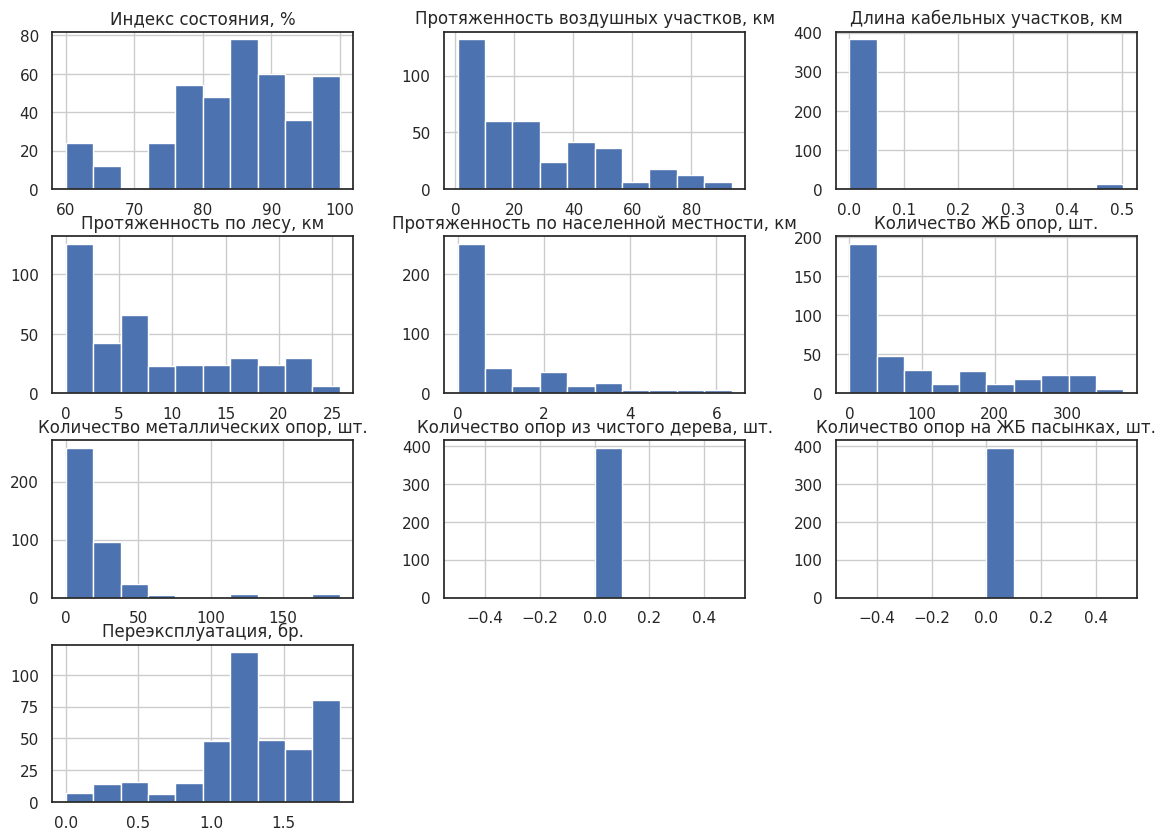

In [39]:
sns.set_theme(context='notebook', style='white', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)
ML_df_110.hist(figsize = (14,10))
plt.show()

In [40]:
ML_df_110.describe(include='all')

,Факт отключения,"Индекс состояния, %","Проводник, тип, сечение",ТИП,"Протяженность воздушных участков, км","Длина кабельных участков, км","Протяженность по лесу, км","Протяженность по населенной местности, км","Количество ЖБ опор, шт.","Количество металлических опор, шт.","Количество опор из чистого дерева, шт.","Количество опор на ЖБ пасынках, шт.",Отношение ЛЭП к транзиту,"Переэксплуатация, бр."
count,395,395.000000,395,395,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.0,395.0,395,395.000000
unique,2,NaN,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
top,Нет,NaN,АС-120,ВЛ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Транзитная,NaN
freq,232,NaN,215,395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,264,NaN
mean,NaN,84.536709,NaN,NaN,26.247258,0.015281,8.435456,0.953727,93.189873,17.605063,0.0,0.0,NaN,1.274720
std,NaN,9.835476,NaN,NaN,23.013822,0.086439,7.252263,1.468451,109.803271,29.031245,0.0,0.0,NaN,0.420690
min,NaN,60.000000,NaN,NaN,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,NaN,0.000000
25%,NaN,79.000000,NaN,NaN,5.388000,0.000000,1.458000,0.000000,1.000000,1.000000,0.0,0.0,NaN,1.114286
50%,NaN,86.000000,NaN,NaN,20.759000,0.000000,6.882000,0.190000,38.000000,10.000000,0.0,0.0,NaN,1.285714
75%,NaN,91.000000,NaN,NaN,43.837000,0.000000,14.007000,1.392000,180.000000,22.000000,0.0,0.0,NaN,1.628571


Полученные характеристики, представленные в таблицах, позволяют сделать вывод, что ЛЭП напряжением 110 кВ в Орловской области строятся на ЖБ и металлических опорах, поскольку параметры, содержащие информацию о количестве опор на ЖБ пасынках и из чистого дерева имеют нулевые значения, поэтому они были удалены. Также были удалены параметры «Длина кабельных участков» и «ТИП», так как первый был представлен только одним значением (только одна ЛЭП частично была выполнена кабельной линией), а второй - только одним уникальным значением «ВЛ», что сделало невозможным их использования для дальнейшего анализа.

In [41]:
ML_df_110 = ML_df_110.drop(["ТИП",
                            "Длина кабельных участков, км",
                            "Количество опор из чистого дерева, шт.",
                            "Количество опор на ЖБ пасынках, шт."], axis=1)

Рассмотрим основные статистические характеристики признаков только в разрезе целевого признака, что позволит определить влияние каждого на отключения электроэнергии на ЛЭП напряжением 110 кВ. Посмотрим на распределение значений категориальных признаков, включая целевой признак.

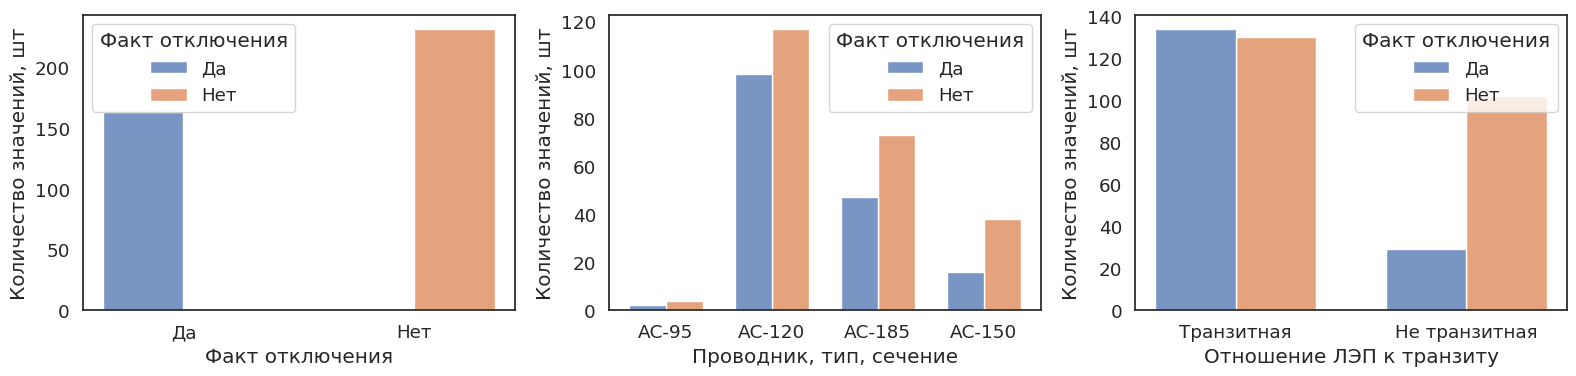

In [42]:
col_list = ML_df_110.select_dtypes(include='object').columns.tolist()

pic_box = plt.figure(figsize=(16,4))
sns.set_theme(context='notebook', style='white', palette='deep', font='sans-serif', font_scale=1.2, color_codes=True, rc=None)

for i in range(len(ML_df_110.select_dtypes(include='object').columns.tolist())):
    pic_box.add_subplot(1,3,i+1)
    sns.histplot(data=ML_df_110, x=col_list[i], hue='Факт отключения', multiple='dodge', shrink = 0.7, stat='count'
                ).set_ylabel('Количество значений, шт')
plt.tight_layout()

Графики показывают небольшой дисбаланс классов целевого признака «Факт отключения» в районе 20%, что может вызвать определенные трудности в случае, если понадобится проводить классификацию с помощью определенных моделей машинного обучения, восприимчивых к этой проблеме. Также этот факт стоит учитывать при анализе распределения параметров ЛЭП в разрезе целевого признака, так как количество значений параметров для ЛЭП, не подвергавшихся отключения электроэнергии, всегда будет превышать количество значений подвергавшихся ЛЭП.
Также) представлено распределение типов проводов по ЛЭП напряжением 110 кВ, из которого видно, что наиболее популярным является неизолированный сталеалюминиевый провод с алюминиевой жилой сечением 120 мм2. (216 линий), далее следует провод сечением 185 мм2 (120 линий) и 150 мм2 (54 линий). Провод АС-95 используется крайне редко – только в 6 случаях. Из представленного графика видно, что вероятность отключения электроэнергии увеличивается (до 45%) при использовании АС сечением 120 мм2, тогда как для провода АС-150 оно составляет 29%, для АС-185 – 39%. Данный факт может быть связан с отношением ЛЭП к транзиту, так как провода типа АС сечением 150 и 185 чаще являются чаще транзитными (в процентном соотношении в 78% и 80% случаях, соответственно), чем АС-150 (56% случаев). На Рисунке 1(в) видна явная зависимость отношения ЛЭП к транзиту на вероятность отключения электроэнергии. Из 132 не транзитных ЛЭП только на 29 линиях были зафиксированы отказы, тогда как на транзитных ЛЭП в количестве 264 штук отключения электроэнергии наблюдались уже у более, чем половины линий (134 шт.).



Рассмотрим распределение признаков с количественными значениями:


Индекс состояния, % :



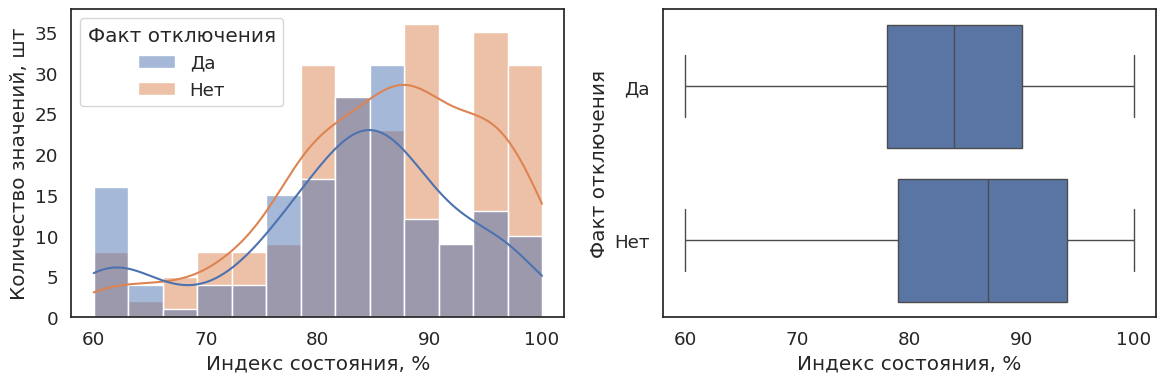


Протяженность воздушных участков, км :



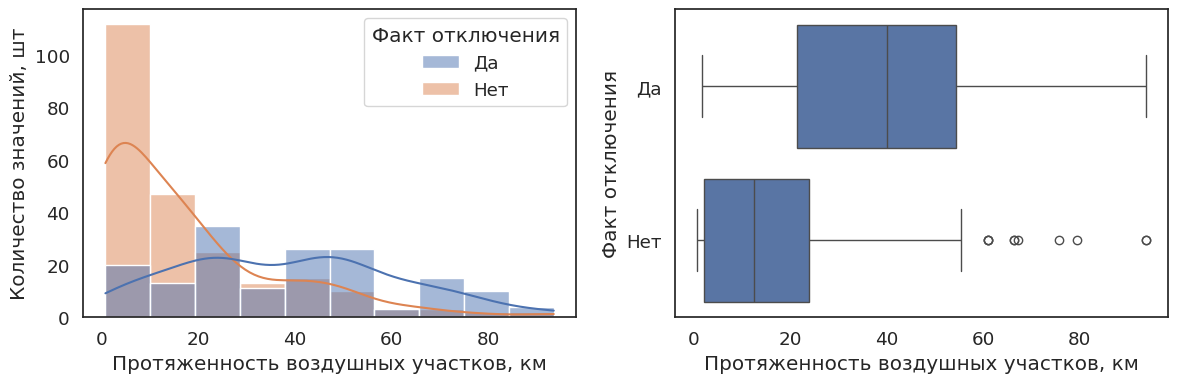


Протяженность по лесу, км :



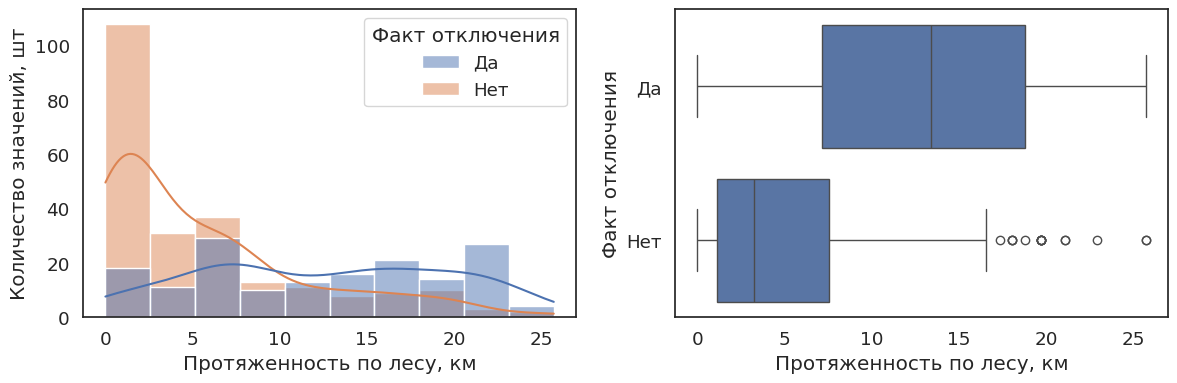


Протяженность по населенной местности, км :



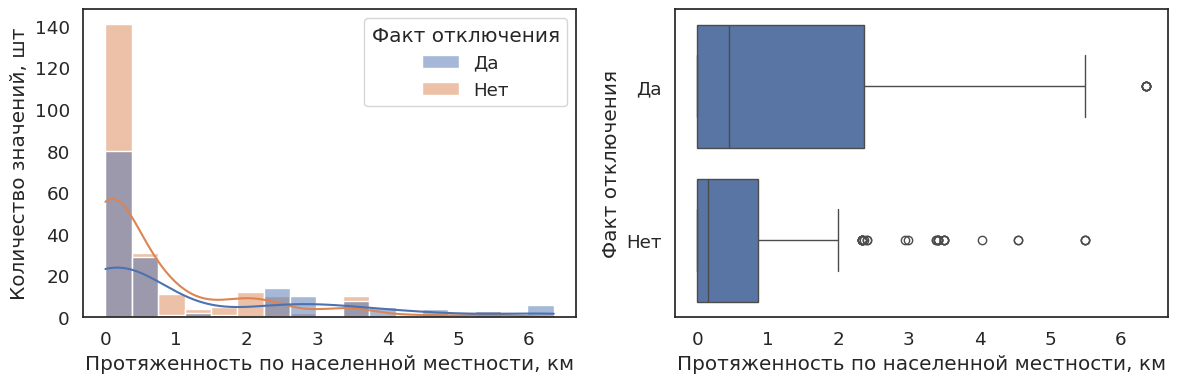


Количество ЖБ опор, шт. :



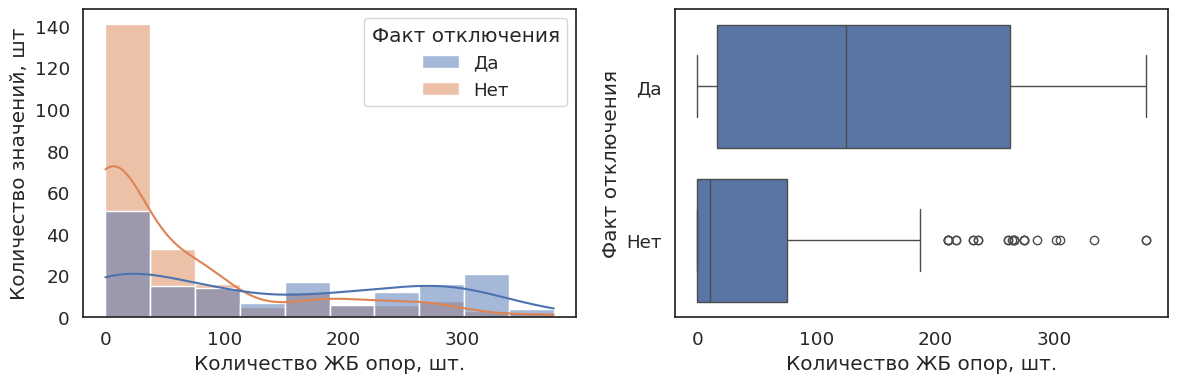


Количество металлических опор, шт. :



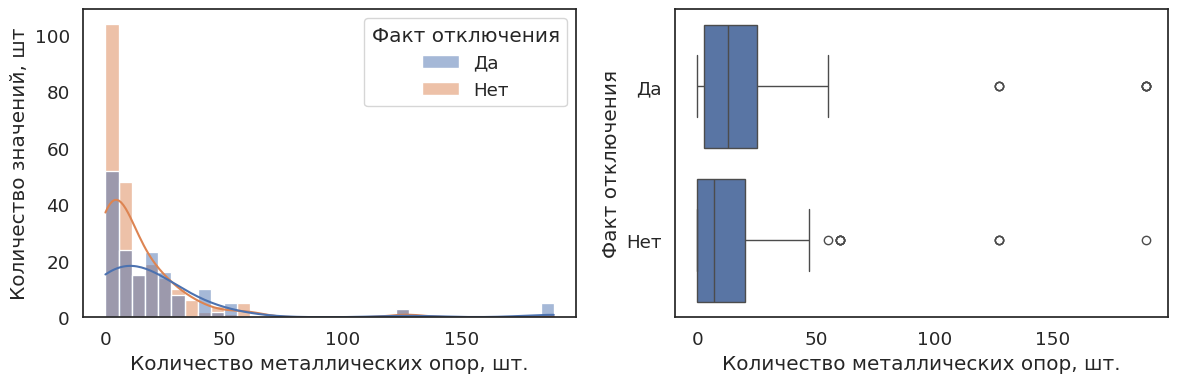


Переэксплуатация, бр. :



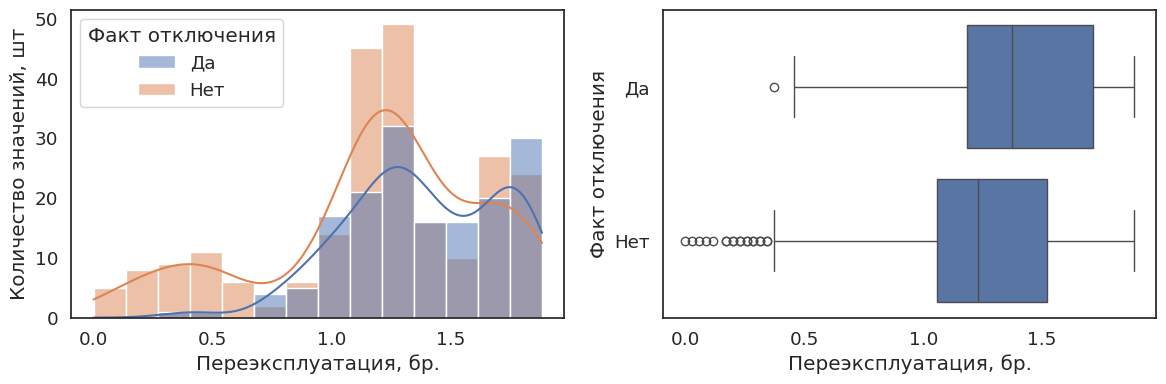

In [43]:
def analysis_quantitatives(features_list):
    for i in features_list:
        print()
        print('\033[1m' + i,':' +'\033[0m')
        print()
        sns.set()
        sns.set_theme(context='notebook', style='white', palette='deep', font='sans-serif', font_scale=1.2, color_codes=True, rc=None)
        lines, axes = plt.subplots(1, 2, figsize=(14, 4))
        sns.histplot(data=ML_df_110, hue='Факт отключения', x=i, ax=axes[0], kde=True,
                    ).set_ylabel('Количество значений, шт')
        sns.boxplot(data=ML_df_110, y='Факт отключения', x=i, ax=axes[1]
                   )
        plt.show()

analysis_quantitatives([x for x in ML_df_110.select_dtypes(include=[np.number]).columns.tolist() if
                        (x!='Чистое дерево' and x!='На ЖБ пасынках' and x!='Длина кабельных\n участков')])

Так как в изначальных предоставляемых данных были ошибки касательно количества опор - некоторые ЛЭП имели нулевые значения по всем типам опор, что невозможно, проанализируем данные признаков не учитывая строки, в которых сумма значений количества ЖБ и металлических опор равняется нулю. Строк с нулевыми суммами опор оказалось 60 шт.


Количество ЖБ опор, шт. :



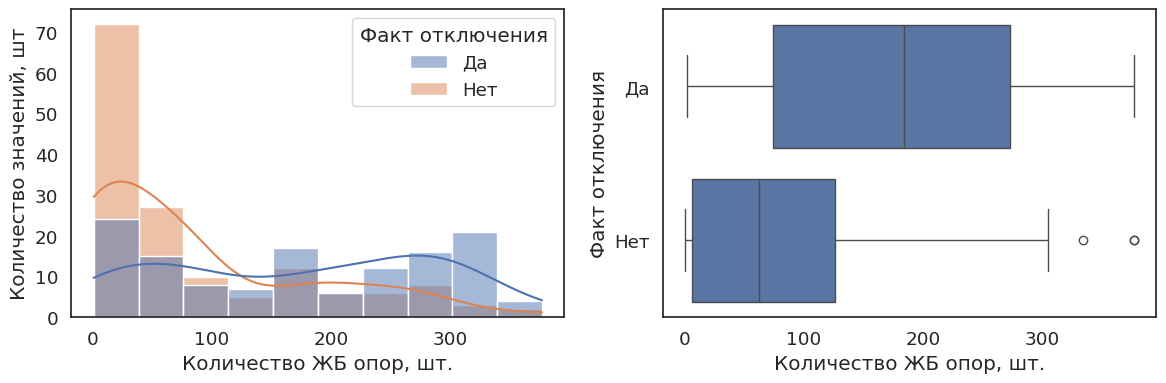


Количество металлических опор, шт. :



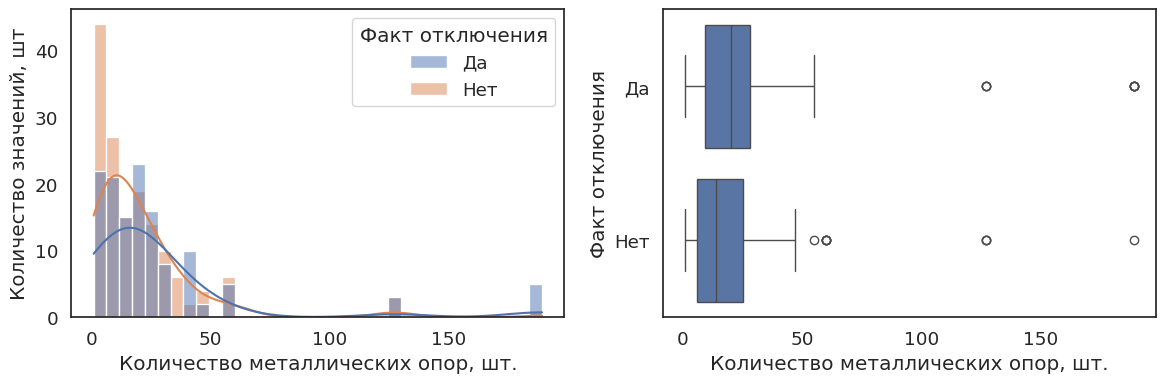

In [44]:
for i in ['Количество ЖБ опор, шт.','Количество металлических опор, шт.']:
    print()
    print('\033[1m' + i,':' +'\033[0m')
    print()
    sns.set()
    sns.set_theme(context='notebook', style='white', palette='deep', font='sans-serif', font_scale=1.2, color_codes=True, rc=None)
    lines, axes = plt.subplots(1, 2, figsize=(14, 4))
    sns.histplot(data=ML_df_110[(ML_df_110['Количество ЖБ опор, шт.']!=0) & (ML_df_110['Количество металлических опор, шт.']!=0)],
                 hue='Факт отключения',
                 x=i, ax=axes[0],
                 kde=True
                ).set_ylabel('Количество значений, шт')
    sns.boxplot(data=ML_df_110[(ML_df_110['Количество ЖБ опор, шт.']!=0) & (ML_df_110['Количество металлических опор, шт.']!=0)],
                y='Факт отключения',
                x=i,
                ax=axes[1])
    plt.show()

**Индекс состояния, %:**

Из представленного графика распределения значений индекса состояния ЛЭП в зависимости от факта, наблюдалось ли отключение на ЛЭП или нет, можно сделать следующие выводы:  

1)	Как видно из графиков, ЛЭП с индексом состояния ниже 60 % не зафиксированы в обоих случаях, выбросов и аномалий в данных нет;

2)	Индекс состояния ЛЭП имеет не большое влияние на вероятность отключения электроэнергии, так средние (медианные) значения индекса состояния для линий, на которых фиксировались отключения, составляет 82% (84%), на которых не фиксировались – 86% (87%);

3)	Нижняя граница интерквантильного расстояния - IQR (25-ый перцентиль) примерно одинакова (78% и 79 % для ЛЭП с отказами и без, соответственно), но есть очевидное различие в верхней границе IQR (75-ый перцентиль) - (78% и 79 %, соответственно). То есть те ЛЭП, которые находятся в более хорошем техническом состоянии, менее подвержены отключениям, что в принципе очевидно

**Протяженность воздушных участков, км:**

Из представленного графика распределения длины воздушных участков ЛЭП в зависимости от факта отключения электроэнергии  можно сделать следующие выводы:

1)	Из представленных графиков подтверждается давно известный факт, что количество отключений электроэнергии зависит от длины ЛЭП, поэтому для оценки эффективности работы энергоснабжающих организаций часто используется параметр поток отказов [10] - количество отказов на определенную длину ЛЭП (например, 1 км), взятое для рассматриваемого момента времени. Несмотря на то, что в рассматриваемом случае отключения наблюдаются при любой длине линий, 25-ый перцентиль длин ЛЭП, подвергавшихся отказам (21.4 км), начинается примерно в том же месте, где закачивается 75-ый перцентиль не подвергавшихся (24,9 км). Средние (медианные) значения длины ЛЭП «с отключениями» составляет 38,9 (40,0) км, без -17,4 (13,0) км.

2)	Так как основная часть ЛЭП, не подвергавшихся отказам, в основном составляют относительно короткие линии, то наблюдаются выбросы в количестве 10 шт., начиная от 60,97 км.  

**Протяженность по лесу, км:**

Похожая картина наблюдается при изучении распределения протяженности ЛЭП по лесу. Средние (медианные) значения протяженности ЛЭП «с отключениями» составляет 12,5 (13,4) км, без -5,6 (3,3) км. Наблюдаются выбросы для ЛЭП, на которых не фиксировались отказы, в количестве 16 шт., начиная от протяженности по лесу в 17,34 км.

**Протяженность по населенной местности, км:**

96 ЛЭП, на которых фиксировались отказы, имеют участки, проходящие по населенной местности, количество линий без отказов, имеющие такие участки, составляет 138 шт. График5 показывают некоторое влияние прохождения ЛЭП по населённой местности на возможность отказа, так нижняя граница интерквантильного расстояния значений протяженности ЛЭП по населённой местности в обоих случаях равна нулю. Верхняя граница IQR (75-ый перцентиль) в случае, если были отказы, составляет 2.37 км, среднее значение - 1.27 км, медиана - 0.45 км. В случае, если отказы не фиксировались, эти параметры равны 0,865 км, 0.73 км и 0.14 км, соответственно. Выбросы наблюдаются в обоих случаях: для ЛЭП, на которых фиксировались отказы, в количестве 6 шт. (Все года ВЛ 110 кВ Мценск – Болхов №2 с протяженностью по населенной местности в 6,354 км.), для ЛЭП, на которых не фиксировались отказы, - 28 шт., начиная от 2,3 к

**Количество ЖБ Опор, шт.:**

На графиках 6 представлено распределение ЛЭП, имеющие ЖБ опоры, из графиков которого можно сделать вывод о влиянии этого вида опор на вероятность отказа ЛЭП. Необходимо отметить, что в изначальных предоставляемых данных были ошибки касательно количества опор, так некоторые ЛЭП имели нулевые значения по всем типам опор, что невозможно. Поэтому при проведении анализа данных признаков не учитывались строки, если сумма значений количества ЖБ и металлических опор равнялось нулю, которых оказалось 60 шт.
Так как количество опор прямо пропорционально протяженности воздушных линий, то ожидаемо малое количество опор будет соответствовать меньшей вероятности возникновения отказов. Среднее количество опор на ЛЭП, на которых не фиксировались отключения электроэнергии, составляет около 87шт. медианное значение – 64 шт., 25-ый перцентиль – 7 шт., 75-ый перцентиль –137шт.,  тогда как для ЛЭП с отказами эти значения составляют 174, 184, 74, 272 шт., соответственно. Выбросы имеются только на ЛЭП без отказов в количестве 35 шт

**Количество металлических опор, шт.:**

Анализ статистический характеристик распределения ЛЭП, имеющие металлические опоры, также приводился без учета строк (60 шт.), в которых сумма значений количества ЖБ и металлических опор равнялось нулюК количеств металлических опор не сильно влияет на вероятность возникновения отказа ЛЭП. Так, в разрезе целевой переменной среднее количество металлических опор на одной линии составляет 21 шт. при условии, что не было зафиксировано отключение электроэнергии, медианное значение составило 14 шт., 25-ый и 75-ый перцентили составили 6 шт. и 25 шт., соответственно. Эти статистические значения для ЛЭП с отказами равнялись 28, 20, 9, 28 шт., соответственно, то есть среднее значение и 75-ый перцентиль равны, что говорит о том, что наблюдается смешение количества металлических опор в сторону уменьшения. Имеются выбросы в количестве 8 и 10 шт. для ЛЭП с отказами и без, соответственно.

 **Переэксплуатация, бр.:**

И имеется небольшая зависимость отключения электрической энергии от переэксплуатации ЛЭП, параметра, синтезированного из срока эксплуатации ЛЭП. Несмотря на то, что графики плотности для обоих значений целевой переменной похожи друг на друга, наблюдается сильная вероятность работы ЛЭП без отказов, если значение переэксплуатации меньше 0,6, то есть срок эксплуатации ЛЭП менее 20 лет. ЛЭП с такими параметрами переэксплуатации немного в количественном значении, поэтому на диаграмме размаха они отмечены как выбросы. С увеличением значения переэксплуатации, начиная приблизительно от 1,3, наблюдается тенденция к увеличению аварийных ситуация на ЛЭП. Касательно статистических характеристик, то среднее и медианное значения для ЛЭП с отказами составляют одинаково 1.38, 25-ый и 75-ый перцентили – 1,19 и 1,71, соответственно. Эти значения для ЛЭП, не подвергавшихся отключения электроэнергии, составили 1,19, 1,22, 1,05 и 1,51, соответственно.

Таким образом, рассмотрев признаки на наличие выбросов можно отметить, что вероятность их появления коррелирует с целевой переменной. Составим таблицу выбросов для каждого признака в разрезе целевой переменной.

In [45]:
fliers_tab = pd.DataFrame(columns=["Признак","Количество выбросов", "Выбросы"])

feature_list = [x for x in ML_df_110.select_dtypes(include=[np.number]).columns.tolist() if
                        (x!='Чистое дерево' and x!='На ЖБ пасынках' and x!='Длина кабельных\n участков')]


_, bp1 = ML_df_110[ML_df_110['Факт отключения']== 'Да'].plot.box(return_type='both')
fliers1 = [flier.get_ydata() for flier in bp1["fliers"]]
for i in range(len(feature_list)):
    fliers_tab.loc[i,"Признак"] = feature_list[i] + ' для ЛЭП с отказами'
    fliers_tab.loc[i,"Количество выбросов"] = len(fliers1[i])
    fliers_tab.loc[i,"Выбросы"] = sorted(fliers1[i])
_.remove()
plt.close()
_, bp2 = ML_df_110[ML_df_110['Факт отключения']== 'Нет'].plot.box(return_type='both')
fliers2 = [flier.get_ydata() for flier in bp2["fliers"]]
for i in range(len(feature_list)):
    fliers_tab.loc[len(feature_list)+i,"Признак"] = feature_list[i] + ' для ЛЭП без отказов'
    fliers_tab.loc[len(feature_list)+i,"Количество выбросов"] = len(fliers2[i])
    fliers_tab.loc[len(feature_list)+i,"Выбросы"] = sorted(fliers2[i])
_.remove()
plt.close()

# fliers_tab.to_excel('fliers_tab.xlsx')
fliers_tab

,Признак,Количество выбросов,Выбросы
0,"Индекс состояния, % для ЛЭП с отказами",0,[]
1,"Протяженность воздушных участков, км для ЛЭП с...",0,[]
2,"Протяженность по лесу, км для ЛЭП с отказами",0,[]
3,"Протяженность по населенной местности, км для ...",6,"[6.354, 6.354, 6.354, 6.354, 6.354, 6.354]"
4,"Количество ЖБ опор, шт. для ЛЭП с отказами",0,[]
5,"Количество металлических опор, шт. для ЛЭП с о...",8,"[127.0, 127.0, 127.0, 189.0, 189.0, 189.0, 189..."
6,"Переэксплуатация, бр. для ЛЭП с отказами",1,[0.37142857142857144]
7,"Индекс состояния, % для ЛЭП без отказов",0,[]
8,"Протяженность воздушных участков, км для ЛЭП б...",10,"[60.971, 60.971, 60.971, 66.457, 66.457, 67.14..."
9,"Протяженность по лесу, км для ЛЭП без отказов",16,"[17.346, 18.053, 18.053, 18.053, 18.804, 19.69..."


Согласно таблице, если на ЛЭП фиксировались отказы, то выбросы наблюдаются в незначительном количестве только для трех параметров: протяженность ЛЭП на населенной местности, количество металлических опор и переэксплуатация (всего лишь 1 выброс). В тоже самое время, рассматривая ЛЭП, на которых фиксировались отказы, видно, что практически для всех её параметров были зафиксированы выбросы в достаточно большом количестве, кроме индекса состояния, что связано с тем, что этот признак является своего рода искусственным параметром, который сотрудники сетевой компании предпочитают держать в определенных пределах (не менее 60 %) на практике или по крайней мере в отчетных документах. Таким образом, можно сделать вывод, что если факт отключения не фиксировался, то такие ЛЭП будут иметь меньший размер статистически значимой выборки и значения будут стремиться быть в границах интерквартильного расстояния. Проанализировав выбросы, было принято решение не удалять их, так как эти выбросы не являются ошибками ввода или случайными событиями, а линии электропередачи с такими параметрами действительно существуют, поэтому они должны быть включены в дальнейшее исследование.

Признак 'Длина кабельных\n участков' распределен крайне неравномерно, что объяснимио малым количестовм значений в столбюце. /Рекомендуется не использовать этот признак для поставленной задачи. Признаки 'Чистое дерево', 'На ЖБ пасынках' рекомендуется удалить , так как они не имеют каких либо значений.

## Проверка корреляции признаков

Одним из основных этапов разведочного анализа данных является корреляционный анализ, позволяющий определить взаимосвязи между различными параметрами, что в конечном итоге, позволяет сделать выводы о степени влиянии одних параметров на другие. Коэффициент корреляции позволяет измерить степень линейной зависимости между двумя переменными. Самой распространенной мерой для определения корреляции между переменными является коэффициент корреляции Пирсона, представляющий собой статистику, которая принимает значения от -1 до +1, при этом значение выше нуля сигнализирует о наличие положительной линейной связи между рассматриваемыми переменными, значение ниже нуля – о наличии отрицательной линейной связи, значение 0 - об отсутствии какой-либо взаимосвязи. Однако, коэффициент Пирсона по своей конструкции работает только для интервальных переменных, что делает не удобным его использование при работе со смешанными типами данных. Поэтому, если имеются категориальные переменные, то рекомендуется использовать другие меры корреляции, например коэффициент корреляции phi ϕk. Корреляция ϕk следует единообразному подходу для интервальных, порядковых и категориальных переменных, поскольку ее определение инвариантно относительно порядка значений каждой переменной. По сути, каждая переменная рассматривается так, как если бы ее тип был категориальным. Суть метода основана на подсчете статистики χ2 (хи-квадрат) Пирсона и ее приведении к значениям на отрезке 0…1, где 1 сигнализирует о максимальной корреляции между переменными, 0 - об её отсутствии.

Так как в рассматриваемых параметрах ЛЭП имеются категориальные значения, то воспользуемся коэффициент корреляции ϕk, однако, чтобы установить направления связи (положительные или отрицательные) между количественными значениями воспользуемся расчётом коэффициента Пирсона. Отобразим все значения корреляции на тепловых картах, графических представлениях матрицы данных, где цветовая шкала показывает степень взаимосвязи между переменными, при этом построим на рисунке 8 тепловую карту для матрицы корреляции ϕk, а на рисунке 9 – для матрицы корреляции Пирсона


In [46]:
phik_overview = ML_df_110.phik_matrix(interval_cols=['Индекс состояния, %',
                                                     'Протяженность воздушных участков, км',
                                                     'Протяженность по лесу, км',
                                                     'Протяженность по населенной местности, км',
                                                     'Количество ЖБ опор, шт.',
                                                     'Количество металлических опор, шт.',
                                                     'Переэксплуатация, бр.'
                                                     ])

In [47]:
phik_overview.sort_values(by='Факт отключения',
                          ascending=False).style.background_gradient(cmap = 'coolwarm')

,Факт отключения,"Индекс состояния, %","Проводник, тип, сечение","Протяженность воздушных участков, км","Протяженность по лесу, км","Протяженность по населенной местности, км","Количество ЖБ опор, шт.","Количество металлических опор, шт.",Отношение ЛЭП к транзиту,"Переэксплуатация, бр."
Факт отключения,1.000000,0.231537,0.108986,0.627335,0.606797,0.317304,0.467248,0.297828,0.402634,0.312147
"Протяженность воздушных участков, км",0.627335,0.651230,0.456844,1.000000,0.953817,0.850437,0.957913,0.647855,0.606879,0.723080
"Протяженность по лесу, км",0.606797,0.694120,0.474146,0.953817,1.000000,0.853304,0.921236,0.633442,0.487239,0.675666
"Количество ЖБ опор, шт.",0.467248,0.652920,0.515106,0.957913,0.921236,0.873139,1.000000,0.628163,0.376945,0.713758
Отношение ЛЭП к транзиту,0.402634,0.533967,0.370243,0.606879,0.487239,0.415638,0.376945,0.286276,1.000000,0.845319
"Протяженность по населенной местности, км",0.317304,0.611393,0.642037,0.850437,0.853304,1.000000,0.873139,0.465849,0.415638,0.605472
"Переэксплуатация, бр.",0.312147,0.600293,0.488397,0.723080,0.675666,0.605472,0.713758,0.658198,0.845319,1.000000
"Количество металлических опор, шт.",0.297828,0.507735,0.240981,0.647855,0.633442,0.465849,0.628163,1.000000,0.286276,0.658198
"Индекс состояния, %",0.231537,1.000000,0.459561,0.651230,0.694120,0.611393,0.652920,0.507735,0.533967,0.600293
"Проводник, тип, сечение",0.108986,0.459561,1.000000,0.456844,0.474146,0.642037,0.515106,0.240981,0.370243,0.488397


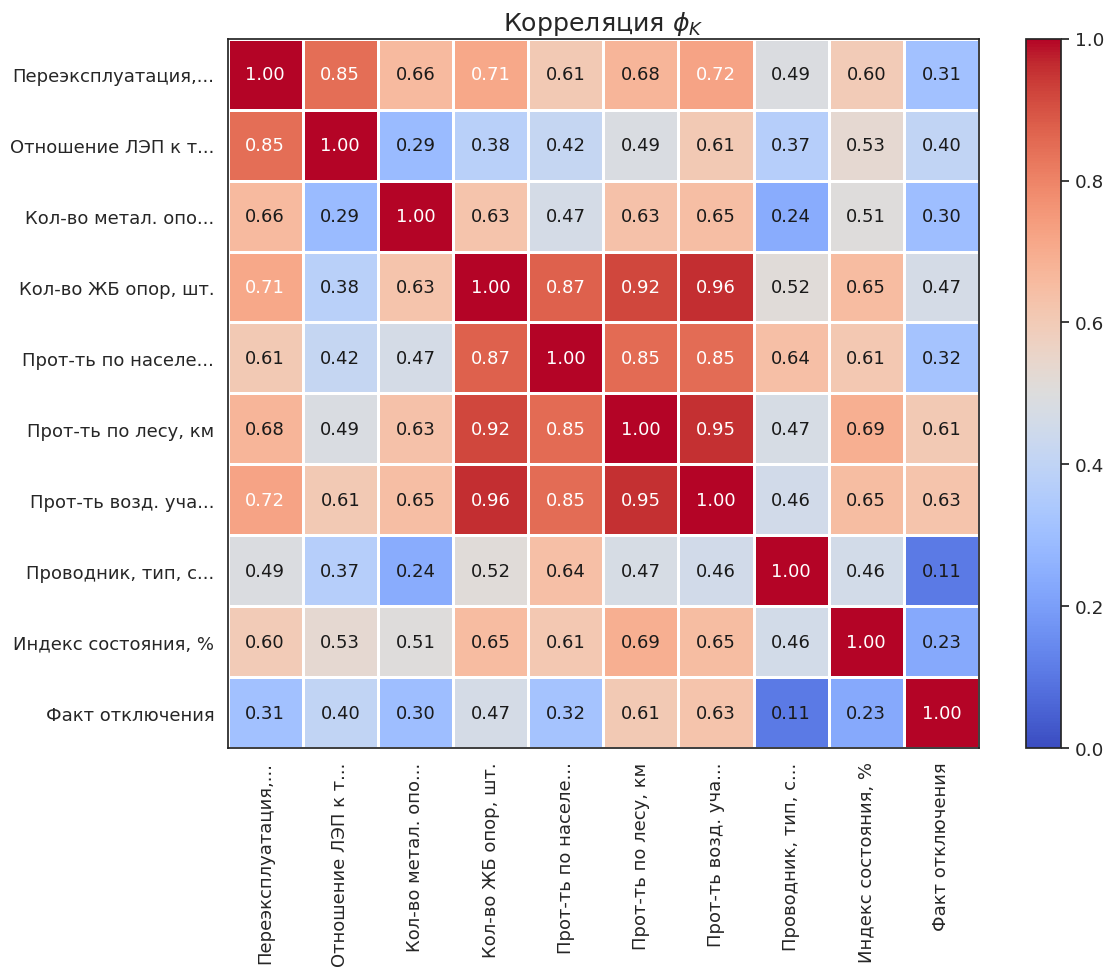

In [48]:
# Редактирование названия признаков для более наглядного отображения на тепловой карте
phik_overview.columns = ['Факт отключения', 'Индекс состояния, %', 'Проводник, тип, сечение',
       'Прот-ть возд. участков, км', 'Прот-ть по лесу, км',
       'Прот-ть по населенной местности, км', 'Кол-во ЖБ опор, шт.',
       'Кол-во метал. опор, шт.', 'Отношение ЛЭП к транзиту',
       'Переэксплуатация, бр.']
phik_overview.index = ['Факт отключения', 'Индекс состояния, %', 'Проводник, тип, сечение',
       'Прот-ть возд. участков, км', 'Прот-ть по лесу, км',
       'Прот-ть по населенной местности, км', 'Кол-во ЖБ опор, шт.',
       'Кол-во метал. опор, шт.', 'Отношение ЛЭП к транзиту',
       'Переэксплуатация, бр.']


# Построение тепловой карты
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map='coolwarm', title=r'Корреляция $\phi_K$', fontsize_factor=1.3,
                        figsize=(12,10))
plt.tight_layout()

Для установления направления связи (положительной или отрицательной) между количественными значениями воспользуемся коэффициентом Пирсона:

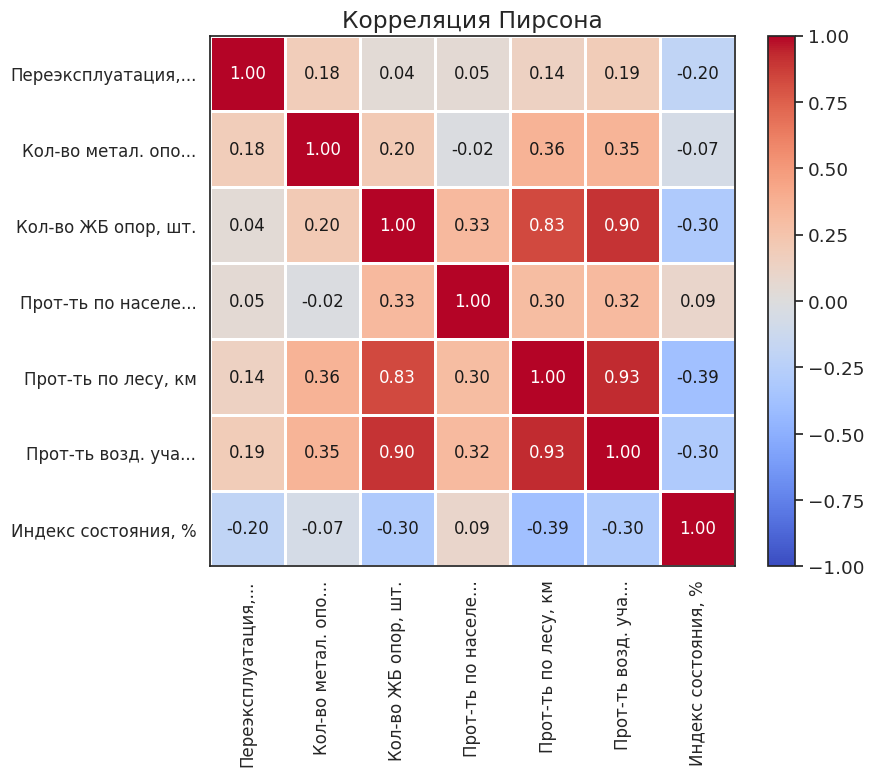

In [49]:
# Расчет корреляции Пирсона
corr = round(ML_df_110[['Индекс состояния, %',
'Протяженность воздушных участков, км',
'Протяженность по лесу, км',
'Протяженность по населенной местности, км',
'Количество ЖБ опор, шт.',
'Количество металлических опор, шт.',
'Переэксплуатация, бр.']].corr(),3)

# Редактирование названия признаков для более наглядного отображения на тепловой карте
corr.columns = ['Индекс состояния, %', 'Прот-ть возд. участков, км',
                'Прот-ть по лесу, км',
                'Прот-ть по населенной местности, км', 'Кол-во ЖБ опор, шт.',
                'Кол-во метал. опор, шт.', 'Переэксплуатация, бр.']
corr.index = ['Индекс состояния, %', 'Прот-ть возд. участков, км',
                'Прот-ть по лесу, км',
                'Прот-ть по населенной местности, км', 'Кол-во ЖБ опор, шт.',
                'Кол-во метал. опор, шт.', 'Переэксплуатация, бр.']


# Построение тепловой карты
plot_correlation_matrix(corr.values, x_labels=corr.columns, y_labels=corr.index,
                        vmin=-1, vmax=1, color_map='coolwarm', title=r'Корреляция Пирсона', fontsize_factor=1.2,
                        figsize=(9,8))
plt.tight_layout()

Из полученных тепловых карт можно сделать несколько выводов о взаимосвязи параметров:


1)	Ни один из параметров ЛЭП не имеет высокую корреляцию с целевой переменной, то есть прямое построение линейной регрессии между двумя параметрами не представляется возможным. Наименьшее влияние на факт отказа ЛЭП оказывают типы использованных проводов, наибольшее влияние – протяженность как всех воздушных участков ЛЭП, так и участков, проходящих по лесу;
   
2)	Небольшое влияние на целевую переменную имеет индекс состояния ЛЭП, что кажется странным, так как если логически предположить, что чем хуже состояния линии, тем больше шанс появления повреждений оборудования на ней, то есть больше вероятность появления отказов на таких ЛЭП. Это может быть объяснено искусственным завышением данного показателя в отчетных документах. Также стоит отметить, что индекс состояния имеет высокую корреляцию с параметром «переэксплуатации», при чем имеет отрицательную связь;
   
3)	Имеется высокая положительная корреляция между всеми параметрами, отображающими протяжённость ЛЭП, а также с количеством ЖБ опор. Это означает, что между рассмотренными независимыми переменными имеется мультиколлинеарность, которая скорее всего приведет к сложности и переобучаемости моделей машинного обучения, поэтому на дальнейших этапах следует исключить переменные, оставив только один, наиболее сильно коррелирующий с целевым признаком;

4)	Выявлена достаточно сильная степень корреляции между сроком эксплуатации линии электропередачи и фактом, является ли ЛЭП транзитной или нет, которая равна 0,85 по степени корреляции ϕk.  Рассмотрим плотность распределения значений и диаграмма размаха для параметра «Переэксплуатация, бр» в разрезе параметра «Отношение ЛЭП к транзиту»,

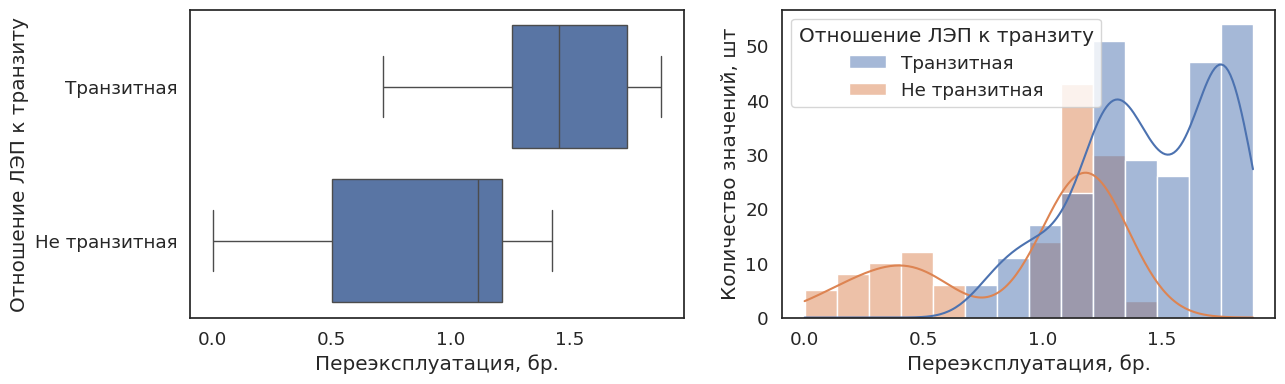

In [50]:
sns.set()
sns.set_theme(context='notebook', style='white', palette='deep', font='sans-serif', font_scale=1.2, color_codes=True, rc=None)
lines, axes = plt.subplots(1, 2, figsize=(14, 4))
sns.boxplot(data=ML_df_110,
                y='Отношение ЛЭП к транзиту',
                x='Переэксплуатация, бр.',
                ax=axes[0])

sns.histplot(data=ML_df_110,
                 hue='Отношение ЛЭП к транзиту',
                 x='Переэксплуатация, бр.', ax=axes[1],
                 kde=True
                ).set_ylabel('Количество значений, шт')
plt.show()

Из графиков выше видно, что статистически значимая выборка переэксплуатации не транзитных ЛЭП смещена влево по отношению к транзитным ЛЭП, что говорит о том, что срок эксплуатации транзитных линий больше, чем у не транзитных. Таким образом, можно сделать вывод, что при вводе в эксплуатацию ЛЭП она с большей вероятностью будет являться не транзитной, но со временем при увеличении количества потребителей к ней подключат дополнительные линии и её статус изменится на «транзитную».  

In [51]:
# Замена абсолютных значений опор на относительные
ML_df_110['ЖБ Опоры, %'] = ML_df_110['Количество ЖБ опор, шт.'] /(ML_df_110['Количество ЖБ опор, шт.'] +
                                                         ML_df_110['Количество металлических опор, шт.']
                                                        )

ML_df_110['Металлические опоры, %'] = ML_df_110['Количество металлических опор, шт.'] /(ML_df_110['Количество ЖБ опор, шт.'] +
                                                         ML_df_110['Количество металлических опор, шт.']
                                                        )
ML_df_110['Протяженность по лесу, %'] = ML_df_110['Протяженность по лесу, км'
                                                         ] / ML_df_110['Протяженность воздушных участков, км']

ML_df_110['Протяженность по населенной местности, %'] = ML_df_110['Протяженность по населенной местности, км'
                                                         ] / ML_df_110['Протяженность воздушных участков, км']



ML_df_110[['ЖБ Опоры, %',
           'Протяженность по лесу, %',
           'Металлические опоры, %',
           'Протяженность по населенной местности, %'
          ]] = ML_df_110[['ЖБ Опоры, %',
                          'Протяженность по лесу, %',
                          'Металлические опоры, %',
                          'Протяженность по населенной местности, %'
                         ]].fillna(0)


ML_df_110 = ML_df_110.drop(['Протяженность по лесу, км',
                            'Протяженность по населенной местности, км',
                            'Количество ЖБ опор, шт.',
                            'Количество металлических опор, шт.'
                           ], axis=1)

print('Размер таблицы:', ML_df_110.shape)
ML_df_110.head()

Размер таблицы: (395, 10)


,Факт отключения,"Индекс состояния, %","Проводник, тип, сечение","Протяженность воздушных участков, км",Отношение ЛЭП к транзиту,"Переэксплуатация, бр.","ЖБ Опоры, %","Металлические опоры, %","Протяженность по лесу, %","Протяженность по населенной местности, %"
0,Да,79,АС-95,13.05,Транзитная,1.171429,0.986667,0.013333,0.506667,0.106667
2,Да,79,АС-95,13.05,Транзитная,1.200000,0.986667,0.013333,0.506667,0.106667
4,Нет,79,АС-95,13.05,Транзитная,1.057143,0.986667,0.013333,0.506667,0.106667
6,Нет,79,АС-95,13.05,Транзитная,1.085714,0.986667,0.013333,0.506667,0.106667
8,Нет,79,АС-95,13.05,Транзитная,1.114286,0.986667,0.013333,0.506667,0.106667


Уберем мультиколлераность, связанную с прямой корреляцией между металическими и ЖБ опорами.

In [52]:
ML_df_110 = ML_df_110.drop('Металлические опоры, %', axis=1)


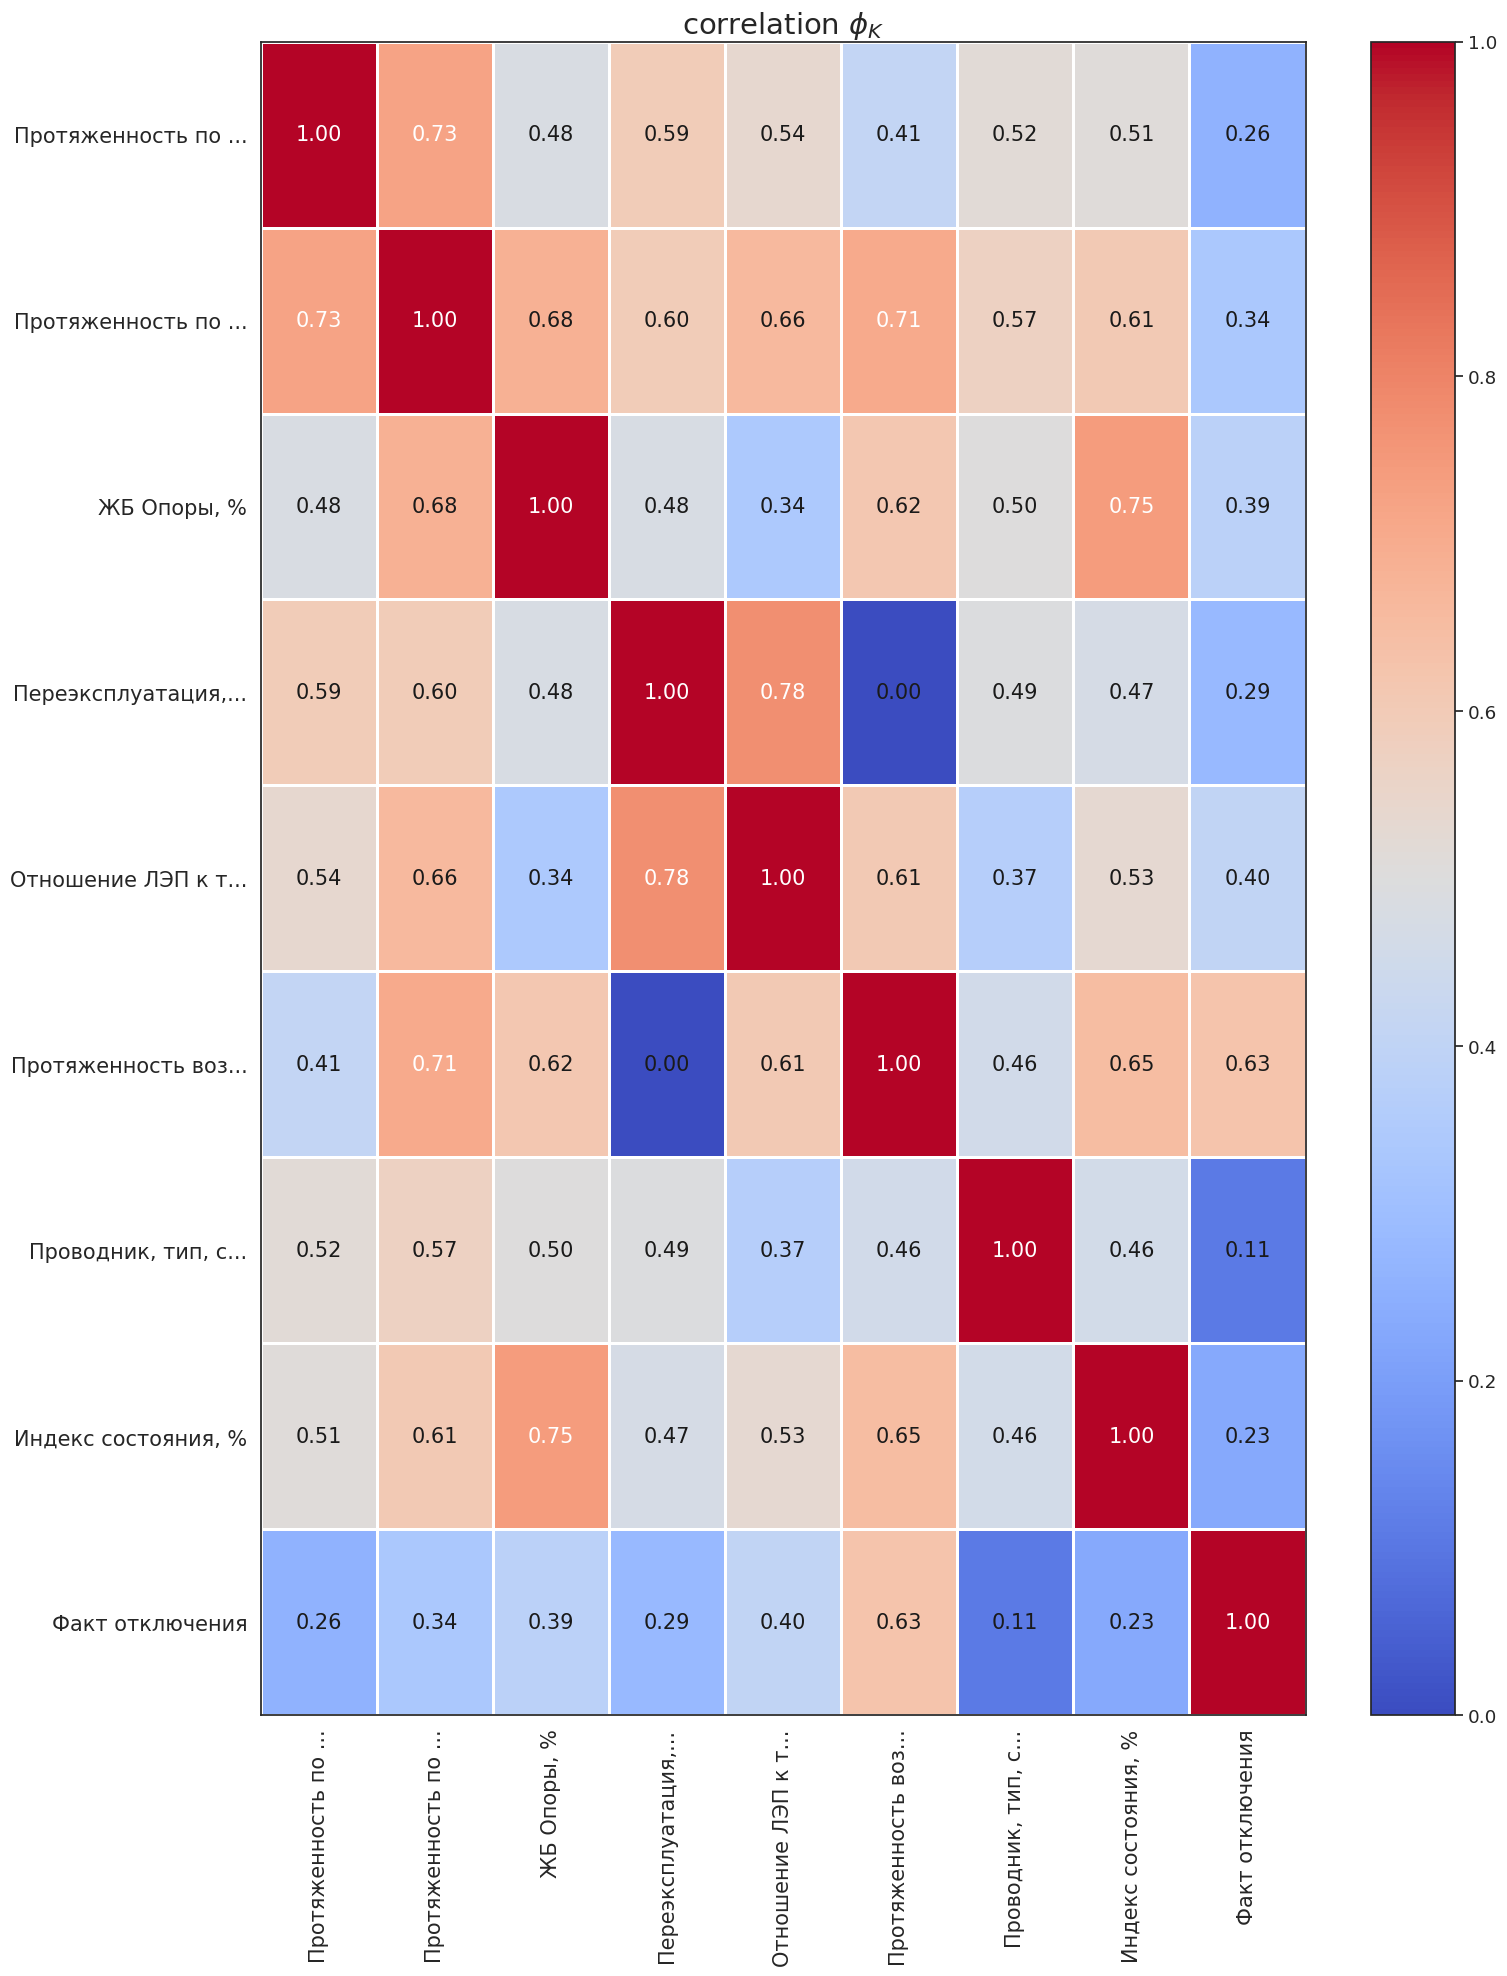

In [53]:
phik_overview = ML_df_110.phik_matrix(interval_cols=['Индекс состояния, %',
                                                     'Протяженность воздушных участков, км',
                                                     'ЖБ Опоры, %',
                                                     'Металлические опоры, %',
                                                     'Протяженность по лесу, %',
                                                     'Протяженность по населенной местности, %'
                                                     ])

plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map='coolwarm', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(16,20))
plt.tight_layout()

In [54]:
phik_overview.sort_values(by='Факт отключения',
                          ascending=False).style.background_gradient(cmap = 'coolwarm')

,Факт отключения,"Индекс состояния, %","Проводник, тип, сечение","Протяженность воздушных участков, км",Отношение ЛЭП к транзиту,"Переэксплуатация, бр.","ЖБ Опоры, %","Протяженность по лесу, %","Протяженность по населенной местности, %"
Факт отключения,1.000000,0.231537,0.108986,0.627335,0.402634,0.285011,0.386451,0.339026,0.260399
"Протяженность воздушных участков, км",0.627335,0.651230,0.456844,1.000000,0.606879,0.000000,0.617107,0.706336,0.407469
Отношение ЛЭП к транзиту,0.402634,0.533967,0.370243,0.606879,1.000000,0.775230,0.341251,0.662493,0.535891
"ЖБ Опоры, %",0.386451,0.745644,0.503546,0.617107,0.341251,0.479762,1.000000,0.684605,0.483779
"Протяженность по лесу, %",0.339026,0.607904,0.573392,0.706336,0.662493,0.597276,0.684605,1.000000,0.725448
"Переэксплуатация, бр.",0.285011,0.471002,0.493147,0.000000,0.775230,1.000000,0.479762,0.597276,0.594504
"Протяженность по населенной местности, %",0.260399,0.508619,0.517872,0.407469,0.535891,0.594504,0.483779,0.725448,1.000000
"Индекс состояния, %",0.231537,1.000000,0.459561,0.651230,0.533967,0.471002,0.745644,0.607904,0.508619
"Проводник, тип, сечение",0.108986,0.459561,1.000000,0.456844,0.370243,0.493147,0.503546,0.573392,0.517872


In [55]:
ML_df_110.to_excel('Data_for_ML_ETL_110kV.xlsx')

#  Рекомендации и будущие исследования


В данном исследовании были подготовлены и обработаны данные по доступным параметрам ЛЭП, которые будут использованы в рамках следующего этапа исследования по построению моделей машинного обучения, способной с определенной точностью идентифицировать линии электропередачи с наибольшей вероятностью отказов и рассчитать в количественном значении степень влияния параметров ЛЭП на вероятность отказа.

Для более точного предсказания моделей машинного обучения предлагается изменить параметры с высокой мультиколлеарностью. Поэтому необходимо будет заменить абсолютные значения количества разных видов опор (железобетонные, металлические) на относительные (выражая в % от общего количества опор). При этом нужно учитывать, что для избежания мультиколлеарности между ЖБ и металлическими опорами, нужно оставить только один их тип, например, железобетонные как наиболее часто встречаемый параметр. Тоже самое необходимо будет провести с параметрами протяженностями по лесу и по населенной местности по отношению к общей протяженности воздушных участков.

Несмотря на то, что выявлена сильная корреляция между сроком эксплуатации линии электропередачи и фактом, является ли ЛЭП транзитной или нет, удаление какого-либо из них не представляется правильным решением, так как у этих параметров разная природа.

# Выводы

В рамках данного исследования были обработаны данные по отключениям электрической энергии и данные по параметрам ЛЭП напряжением 110 кВ.  С помощью методов группировки и слияния табличные данные были подготовлены для анализа. На этом этапе также были удалены параметры, не имеющие отношения к анализу, параметр «срок эксплуатации ЛЭП» стандартизирован путем преобразования в параметр «Переэксплуатация», синтезирван целевой признак – «Факт отключения на ЛЭП». Итоговым результатом стала таблица, содержащая 10 параметров, включая целевой признак, и 395 строк

В ходе анализа установлено, что в целевом признаке наблюдается несбалансированность классов – количество фактов отключения превышает на 20% их отсутствие, что необходимо учитывать при дальнейшем анализе. Выявлена увеличение вероятности отключения электроэнергии при использовании типа провода АС сечением 120 мм2 (до 45%) и наличии фактом транзитной линии. Анализ распределения значений индекса состояния ЛЭП подтвердил, что снижение вероятности отключений наблюдается с улучшением технического состояния ЛЭП, с уменьшением длины линий, уменьшением количества опор. Сильное снижение вероятности отказов наблюдается, если значение переэксплуатации становится меньше 0,6, то есть срок эксплуатации ЛЭП менее 20 лет.

Рассматривая наличие выбросов по методу интерквартильных расстояний, сделан вывод о их взаимосвязи с фактом отказа линии. Так, если факт отключения не фиксировался, то такие ЛЭП будут иметь меньший размер статистически значимой выборки и значения будут стремиться быть в границах интерквартильного расстояния, поэтому у них наблюдается большее количество выбросов.
Корреляционный анализ проводился по двум коэффициентам Пирсона и ϕk, что позволило установить силу и направления связи между значениями параметров. Было выявлено отсутствие сильной корреляции между целевой переменной и другими параметрами, а также наличие мультиколлинеарности между всеми параметрами, отображающими протяжённость ЛЭП и количество ЖБ опор.

%%capture
!pip install nbconvert
import nbconvert

%%capture
!jupyter nbconvert outages-2d_part.ipynb --to pdf --TemplateExporter.exclude_input=True